# Fingerprint-based similarity scores

## Challenge
1. Many different fingerprints AND possible variations thereof (e.g. count/binary, log, weighted...) AND different metrics lead to **a lot** of possible variations!
2. No ground truth, so it is hard to measure what is good and what is better...

Data:

Compare multiple fingerprints on the "ms2 structures" dataset [Bushuiev 2024].

In [1]:
import os
import sys
from pathlib import Path
import pickle
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdFingerprintGenerator
ROOT = Path(os.getcwd()).parents[0]

path_data = os.path.join(Path(ROOT), "data")

## Data: Combination of MassSpecGym + MS2DeepScore

In [7]:
filename = "compounds_ms2structures_251202.csv"
compounds = pd.read_csv(os.path.join(path_data, filename))
compounds.head()

,inchikey,smiles,mass,cf_class,cf_subclass,cf_superclass,formula,npc_class_results,npc_pathway_results,npc_superclass_results
0,AAAQFGUYHFJNHI,CCNC(=O)C[C@H]1C2=NN=C(N2C3=C(C=C(C=C3)OC)C(=N...,423.146204,Benzodiazepines,"1,4-benzodiazepines",Organoheterocyclic compounds,C22H22ClN5O2,NaN,Alkaloids,NaN
1,AABFWJDLCCDJJN,COC1=CC2=C(C=C1)NC3=C2C=CN=C3C4=CC=CC5=CC=CC=C54,324.126264,Harmala alkaloids,NaN,Alkaloids and derivatives,C22H16N2O,Carboline alkaloids,Alkaloids,Tryptophan alkaloids
2,AABILZKQMVKFHP,C/C=C(/C)\C(=O)O[C@H]1CC[N+]2([C@@H]1C(=CC2)CO...,427.220624,NaN,NaN,Alkaloids and derivatives,C21H33NO8,Pyrrolizidine alkaloids,Alkaloids,Ornithine alkaloids
3,AABUHSBGEIUSRJ,CC(=O)NC1=CC=C(C=C1)NC(=O)C=CC2=CC=CC=C2,280.120724,Cinnamic acids and derivatives,Cinnamic acid amides,Phenylpropanoids and polyketides,C17H16N2O2,Cinnamic acid amides,Shikimates and Phenylpropanoids,Phenylpropanoids (C6-C3)
4,AABUKWVVUWBZCS,C1=CC=C(C=C1)C2=C(C(=O)OC3=C2C=CC(=C3)O)C4=CC=...,314.094724,Neoflavonoids,Neoflavones,Phenylpropanoids and polyketides,C21H14O3,Neoflavonoids,Shikimates and Phenylpropanoids,Flavonoids


In [7]:
compounds.describe()

,mass
count,37811.000000
mean,424.170589
std,201.716816
min,31.058000
25%,306.490000
50%,383.172782
75%,483.217489
max,3401.902000


In [2]:
# Add source code path
sys.path.insert(0, os.path.join(ROOT, "src"))

# Import funtion/classes from source code
from fingerprint_computation import FingerprintGenerator, compute_fingerprints_from_smiles

In [17]:
import metrics


def compute_ruzicka_similarities(fingerprints):
    return metrics.ruzicka_similarity_matrix(fingerprints, fingerprints)

def compute_ruzicka_similarities_weighted(fingerprints, weights):
    return metrics.ruzicka_similarity_matrix_weighted(fingerprints, fingerprints, weights)

def compute_ruzicka_similarities_log(fingerprints):
    return metrics.ruzicka_similarity_matrix(np.log(1 + fingerprints), np.log(1 + fingerprints))

def compute_jaccard_similarities(fingerprints):
    return metrics.jaccard_similarity_matrix(fingerprints, fingerprints)

def compute_jaccard_similarities_weighted(fingerprints, weights):
    return metrics.jaccard_similarity_matrix_weighted(fingerprints, fingerprints, weights)

In [14]:
from rdkit.Chem import rdFingerprintGenerator


fpgen = rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=4096)

fingerprints_rdkit = compute_fingerprints_from_smiles(
    compounds.smiles, fpgen, count=False, sparse=False, progress_bar=True
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37811/37811 [00:35<00:00, 1060.62it/s]


In [22]:
fingerprints_rdkit.sum(axis=1).min()

np.uint64(2)

In [23]:
compounds.shape[0]

37811

In [24]:
%%time

similarities_rdkit = compute_jaccard_similarities(fingerprints_rdkit)

CPU times: user 3min 54s, sys: 1min 12s, total: 5min 6s
Wall time: 15 s


In [16]:
similarities_rdkit.shape

(37811, 37811)

In [25]:
similarities_rdkit[:5, :5]

array([[1.        , 0.16414265, 0.22535211, 0.0787172 , 0.1648299 ],
       [0.16414265, 1.        , 0.14056017, 0.06025267, 0.20114942],
       [0.22535211, 0.14056017, 1.        , 0.06589891, 0.14409369],
       [0.0787172 , 0.06025267, 0.06589891, 1.        , 0.06349207],
       [0.1648299 , 0.20114942, 0.14409369, 0.06349207, 1.        ]],
      dtype=float32)

In [25]:
# similarities_rdkit = similarities_rdkit.astype(np.float16)

In [26]:
# too big! --> 5 GB !!
np.save("similarities_tanimoto_rdkit_4096bits.npy", similarities_rdkit)

In [3]:
similarities_rdkit = np.load("similarities_tanimoto_rdkit_4096bits.npy")

In [28]:
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096)
fingerprints_morgan3_count = compute_fingerprints_from_smiles(
    compounds.smiles, fpgen, count=True, sparse=False, progress_bar=True
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37811/37811 [00:06<00:00, 6254.58it/s]


In [29]:
%%time

similarities_morgan3_count = compute_ruzicka_similarities(fingerprints_morgan3_count)

CPU times: user 1h 12min 3s, sys: 8.9 s, total: 1h 12min 12s
Wall time: 2min 30s


In [15]:
# too big! --> 5 GB !!
np.save("similarities_ruzicka_morgan3_4096bits.npy", similarities_morgan3_count.astype(np.float32))

In [16]:
similarities_morgan3_count = np.load("similarities_ruzicka_morgan3_4096bits.npy")

In [26]:
# similarities_morgan3_count = similarities_morgan3_count.astype(np.float16)

In [31]:
similarities_morgan3_count.shape

(37811, 37811)

## Morgan-3 binary + Tanimoto

In [32]:
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096)
fingerprints_morgan3 = compute_fingerprints_from_smiles(
    compounds.smiles, fpgen, count=False, sparse=False, progress_bar=True
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37811/37811 [00:05<00:00, 6976.93it/s]


In [33]:
%%time

similarities_morgan3 = compute_jaccard_similarities(fingerprints_morgan3)

CPU times: user 3min 52s, sys: 1min 16s, total: 5min 8s
Wall time: 15.1 s


In [13]:
# too big! --> 5 GB !!
np.save("similarities_tanimoto_morgan3_4096bits.npy", similarities_morgan3.astype(np.float32))

In [14]:
similarities_morgan3 = np.load("similarities_tanimoto_morgan3_4096bits.npy")

## Morgan-6 count

In [65]:
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=6, fpSize=4096)

fingerprints_morgan6_count = compute_fingerprints(fpgen, count=True)

  0%|          | 0/37663 [00:00<?, ?it/s]

In [66]:
%%time

similarities_morgan6_count = compute_ruzicka_similarities(fingerprints_morgan6_count)

CPU times: user 1h 8min 57s, sys: 8.09 s, total: 1h 9min 5s
Wall time: 2min 28s


In [69]:
# too big! --> 5 GB !!
np.save("similarities_ruzicka_morgan6_4096bits.npy", similarities_morgan6_count)

## Morgan-9 count

In [35]:
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=9, fpSize=4096)
fingerprints_morgan9_count = compute_fingerprints_from_smiles(
    compounds.smiles, fpgen, count=True, sparse=False, progress_bar=True
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37811/37811 [00:09<00:00, 4176.50it/s]


In [36]:
%%time

similarities_morgan9_count = compute_ruzicka_similarities(fingerprints_morgan9_count)

CPU times: user 1h 12min 23s, sys: 8.86 s, total: 1h 12min 31s
Wall time: 2min 30s


In [11]:
# too big! --> 5 GB !!
np.save("similarities_ruzicka_morgan9_4096bits.npy", similarities_morgan9_count.astype(np.float32))

In [12]:
similarities_morgan9_count = np.load("similarities_ruzicka_morgan9_4096bits.npy")

## MAP4

In [8]:
from typing import List
from rdkit.Chem import Mol, MolFromSmiles # pylint: disable=import-error,no-name-in-module
from map4 import MAP4


map4 = MAP4(
    dimensions=4096,
    radius=2,
    include_duplicated_shingles=True,
)

mol = MolFromSmiles(compounds.smiles[4])

fp_map4 = map4._calculate(mol)
len(fp_map4)

552

In [39]:
map4 = MAP4(
    dimensions=4096,
    radius=2,
    include_duplicated_shingles=False,
)

mol = MolFromSmiles(compounds.smiles[4])

fp_map4 = map4._calculate(mol)
len(fp_map4)

272

In [71]:
mol = MolFromSmiles("C[C@H](N)C(=O)O")
fp_map4 = map4._calculate(mol)              
fp_map4

{b'C(C)(C)N|1|C([CH])(=O)O',
 b'C(C)(N)C(=O)O|1|C(=O)(O)C(C)N',
 b'CC(C)N|1|C(C)(N)C(=O)O',
 b'CC(C)N|2|C(=O)(O)C(C)N',
 b'CC(C)N|2|NC(C)C',
 b'CC(C)N|3|O=C([CH])O',
 b'CC(C)N|3|OC([CH])=O',
 b'C[CH]|1|C(C)(C)N',
 b'C[CH]|2|C([CH])(=O)O',
 b'C[CH]|2|N[CH]',
 b'NC(C)C|1|C(C)(N)C(=O)O',
 b'NC(C)C|2|C(=O)(O)C(C)N',
 b'NC(C)C|3|O=C([CH])O',
 b'NC(C)C|3|OC([CH])=O',
 b'N[CH]|1|C(C)(C)N',
 b'N[CH]|2|C([CH])(=O)O',
 b'O=C([CH])O|1|C(=O)(O)C(C)N',
 b'O=C([CH])O|2|C(C)(N)C(=O)O',
 b'O=C([CH])O|2|OC([CH])=O',
 b'O=C|1|C([CH])(=O)O',
 b'O=C|2|C(C)(C)N',
 b'O=C|3|C[CH]',
 b'O=C|3|N[CH]',
 b'OC([CH])=O|1|C(=O)(O)C(C)N',
 b'OC([CH])=O|2|C(C)(N)C(=O)O',
 b'OC|1|C([CH])(=O)O',
 b'OC|2|C(C)(C)N',
 b'OC|2|O=C',
 b'OC|3|C[CH]',
 b'OC|3|N[CH]'}

In [9]:
map4 = MAP4(
    dimensions=4096,
    radius=2,
    include_duplicated_shingles=False,
)

molecules: List[Mol] = [MolFromSmiles(smiles) for smiles in tqdm(compounds.smiles.values)]
fingerprints_map4: np.ndarray = map4.calculate_many(
    molecules,
    number_of_threads=32,
    verbose=True,
)

  0%|          | 0/37811 [00:00<?, ?it/s]

Calculating fingerprints:   0%|                                                                               …

In [42]:
fingerprints_map4.shape

(37811, 4096)

In [10]:
similarities_morgan3_count.dtype

dtype('float64')

In [18]:
%%time

similarities_map4 = compute_jaccard_similarities(fingerprints_map4).astype(np.float32)

CPU times: user 4min 3s, sys: 1min 11s, total: 5min 15s
Wall time: 16.1 s


In [55]:
map2 = MAP4(
    dimensions=4096,
    radius=1,
    include_duplicated_shingles=False,
)

molecules: List[Mol] = [MolFromSmiles(smiles) for smiles in tqdm(compounds.smiles.values)]
fingerprints_map2: np.ndarray = map2.calculate_many(
    molecules,
    number_of_threads=32,
    verbose=True,
)

  0%|          | 0/37811 [00:00<?, ?it/s]

Calculating fingerprints:   0%|                                                                               …

In [56]:
%%time

similarities_map2 = compute_jaccard_similarities(fingerprints_map2)

CPU times: user 3min 57s, sys: 1min 4s, total: 5min 2s
Wall time: 14.9 s


## Compare score distributions

Things to consider:
- remove the diagonal (to not count the pairs of compounds with themselves)
- different scores will scale very differently -- adjust scale/align between all scores!

In [49]:
#from utils import remove_diagonal

def remove_diagonal(A):
    m = A.shape[0]
    strided = np.lib.stride_tricks.as_strided
    s0,s1 = A.strides
    return strided(A.ravel()[1:], shape=(m-1,m), strides=(s0+s1,s1)).reshape(m,-1)



def compare_distributions(
    similarities1,
    similarities2,
    label1,
    label2,
    title="",
    ignore_diagonal=True,
    filename=None
):
    if ignore_diagonal:
        similarities1 = remove_diagonal(similarities1)
        similarities2 = remove_diagonal(similarities2)

    fig, ax = plt.subplots(1, figsize=(8, 5))
    ax.hist(similarities1.reshape(-1),
                    bins=50, rwidth=0.8, alpha=0.5, label=label1)
    ax.hist(similarities2.reshape(-1),
                    bins=50, rwidth=0.8, alpha=0.5, label=label2)
    ax.set_title(title)
    ax.set_xlabel("Tanimoto(-like) score")
    ax.set_ylabel("Score counts")
    
    ax.set_yscale("log")
    ax.set_yscale("log")
    plt.legend()
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename, dpi=600)
    plt.show()

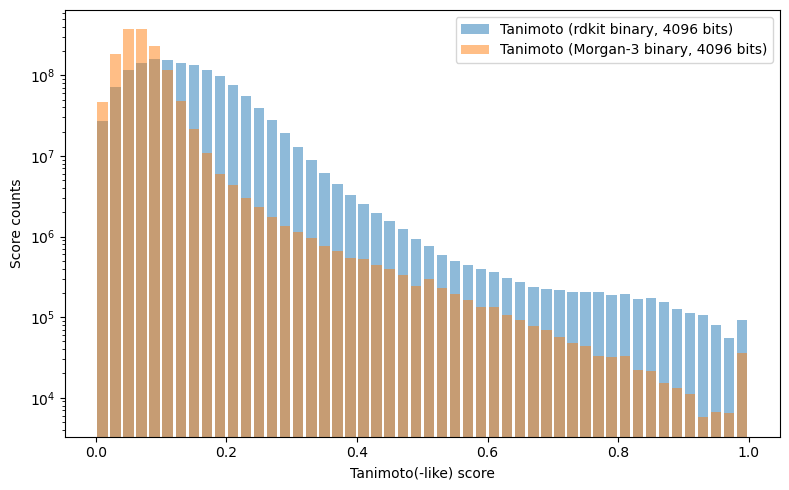

In [51]:
NBITS = 4096

compare_distributions(
    similarities_rdkit,
    similarities_morgan3,
    f"Tanimoto (rdkit binary, {NBITS} bits)",
    f"Tanimoto (Morgan-3 binary, {NBITS} bits)",
    ignore_diagonal=True,
    filename="score_distributions_tanimoto_rdkit_vs_morgan3.png"
)

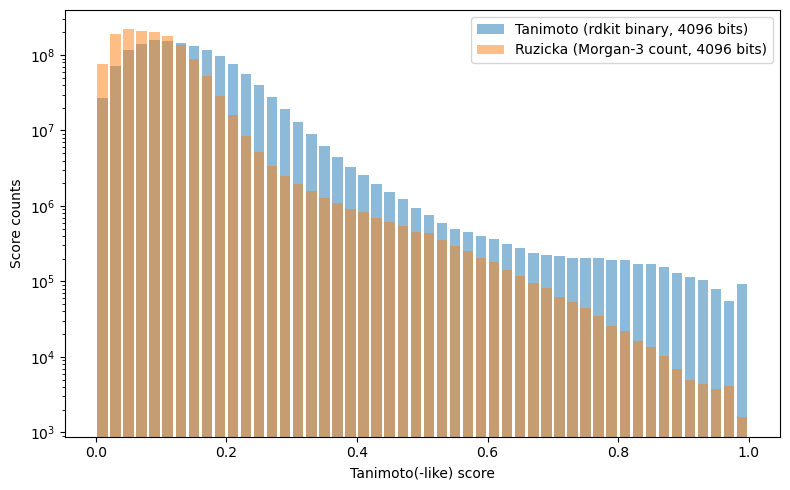

In [52]:
NBITS = 4096

compare_distributions(
    similarities_rdkit,
    similarities_morgan3_count,
    f"Tanimoto (rdkit binary, {NBITS} bits)",
    f"Ruzicka (Morgan-3 count, {NBITS} bits)",
    ignore_diagonal=True,
    filename="score_distributions_tanimoto_rdkit_vs_ruzicka_morgan3.png"
)

## Compare score vs. score using heatmap

In [20]:
from visualizations import heatmap_comparison

## Compare score distributions for small and larger molecules

8601 8570


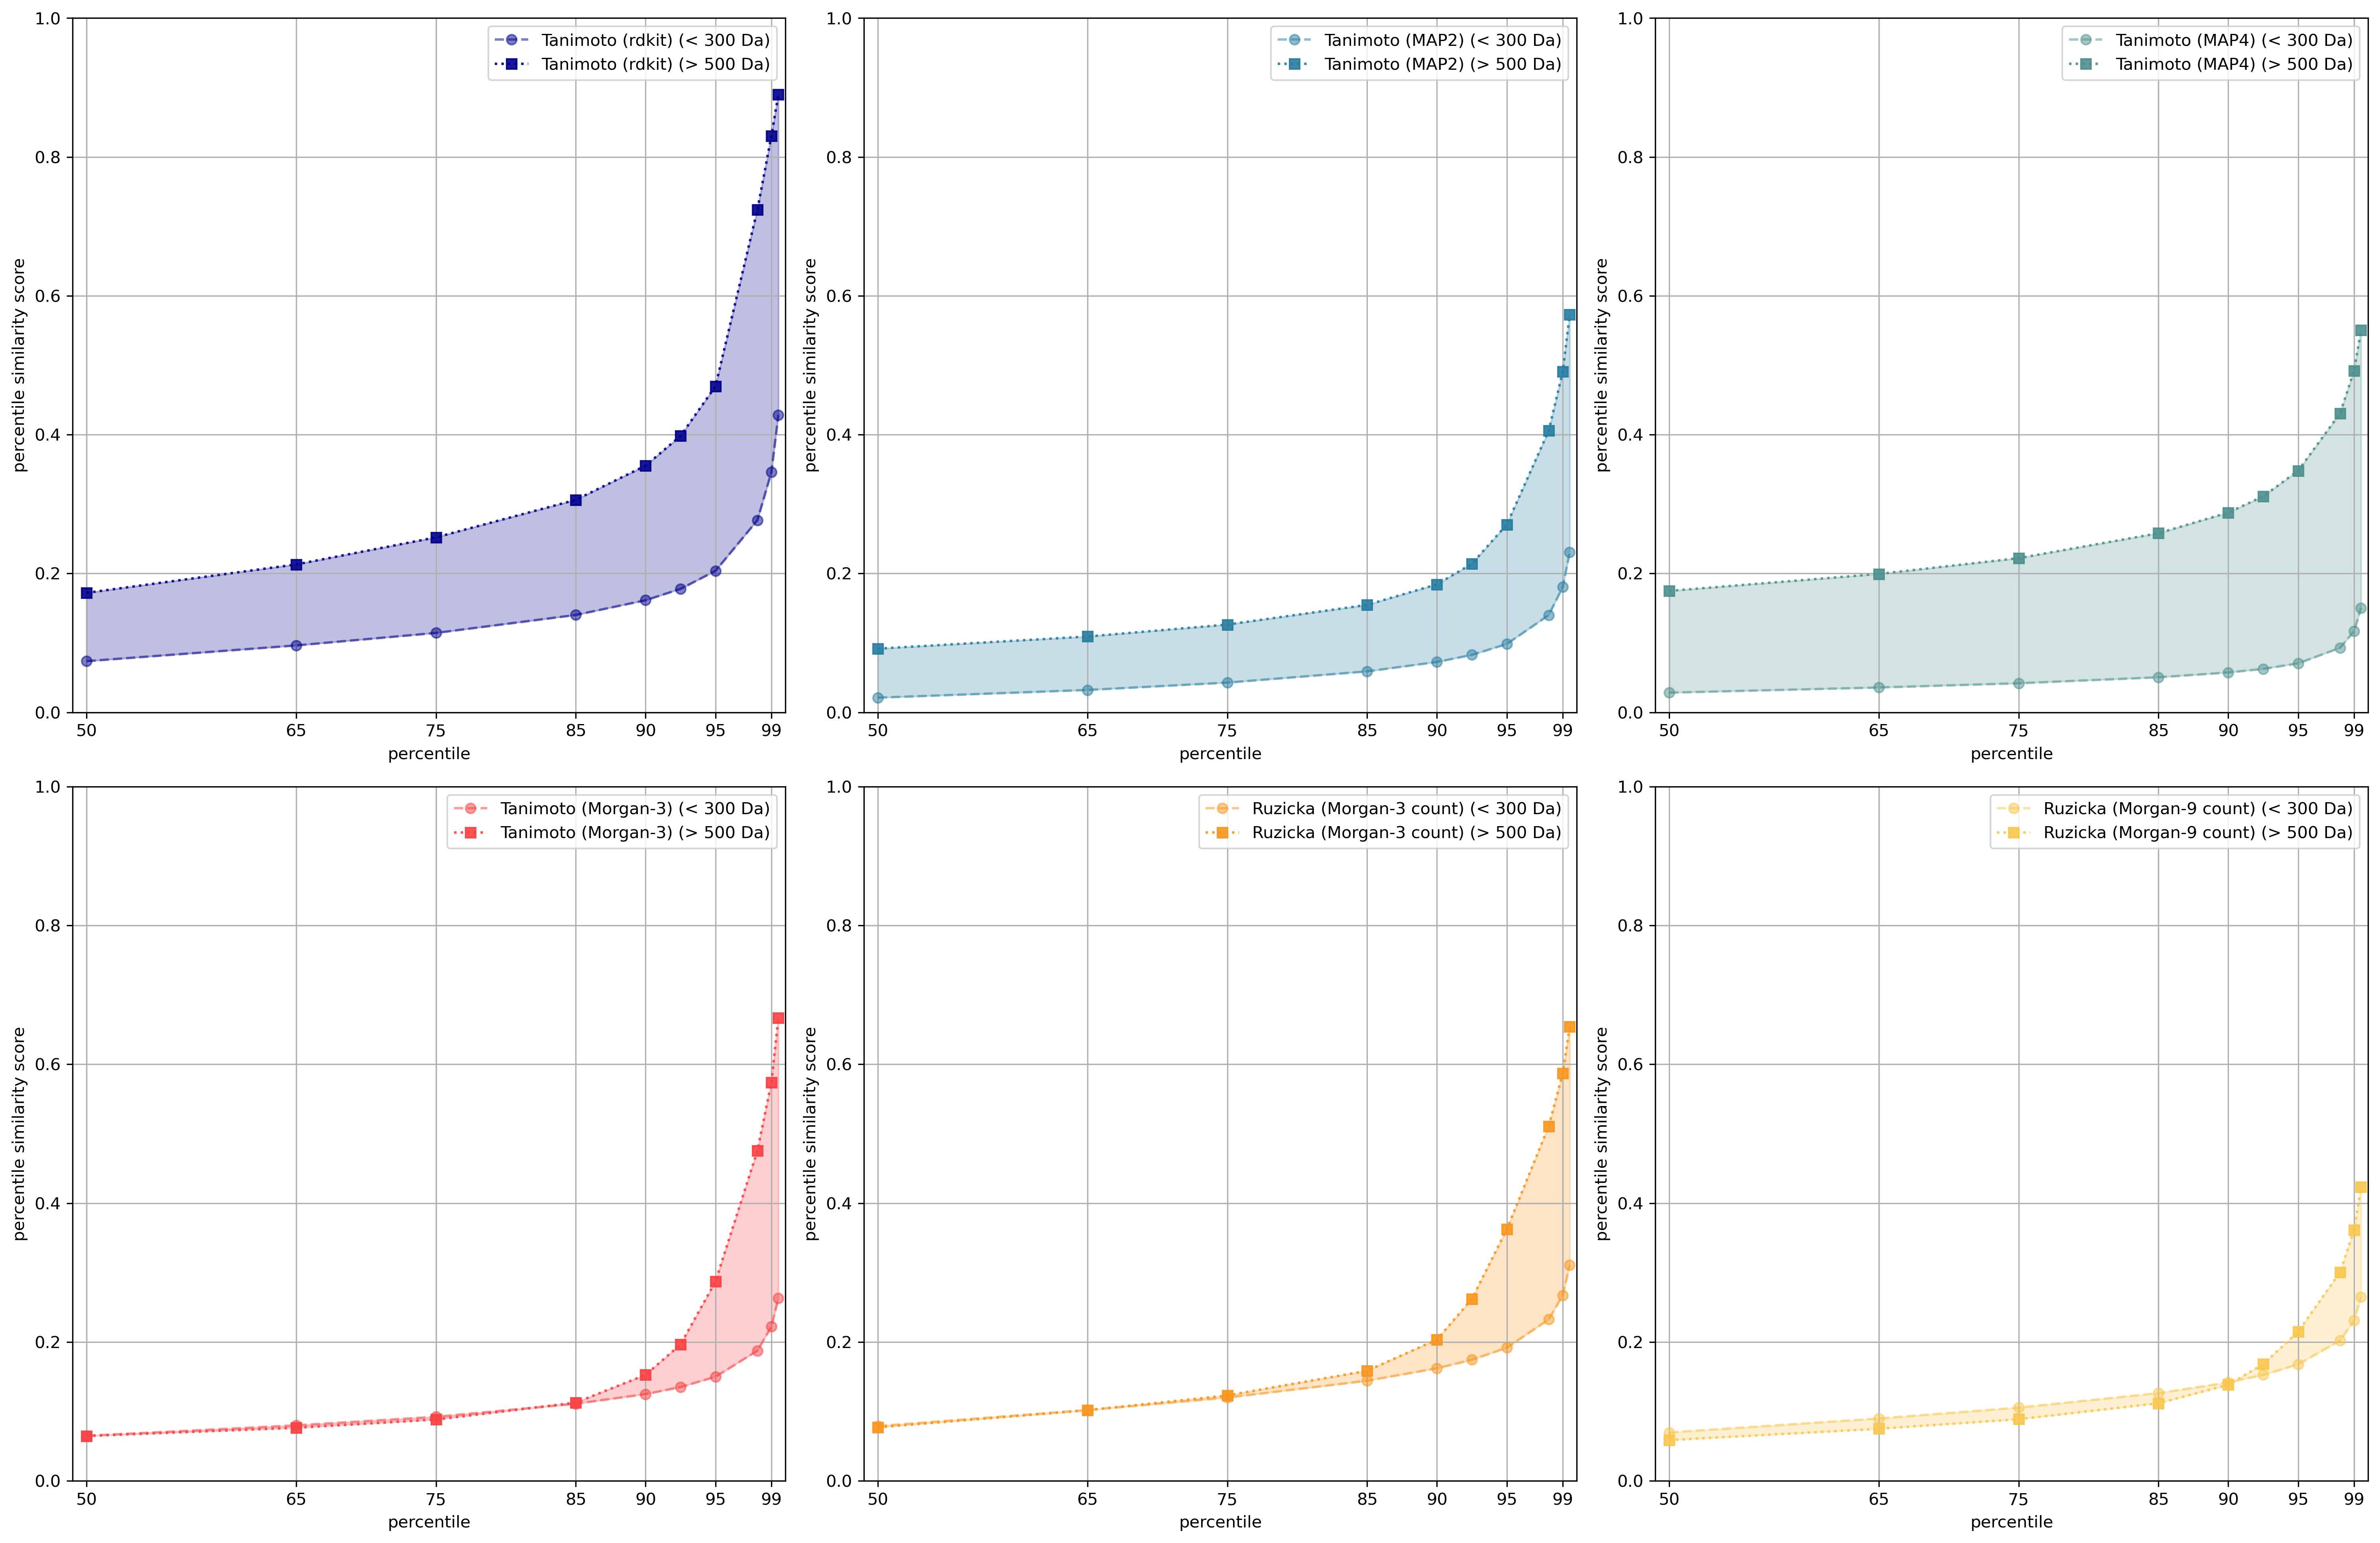

In [57]:
#percentiles = np.arange(0, 101)
percentiles = [50, 65, 75, 85, 90, 92.5, 95, 98, 99, 99.5] #, 99.9]
percentiles_ticks = [50, 65, 75, 85, 90, 95, 99]

mass_low = 300
mass_high = 500

idx1 = np.where(compounds.mass > mass_high)[0]
idx0 = np.where(compounds.mass < mass_low)[0]
print(idx0.shape[0], idx1.shape[0])

similarities_dict = {
    "Tanimoto (rdkit)": similarities_rdkit,
    "Tanimoto (MAP2)": similarities_map2,
    "Tanimoto (MAP4)": similarities_map4,
    "Tanimoto (Morgan-3)": similarities_morgan3,
    #"Ruzicka (Morgan-2 count, 4096 bits)": similarities_morgan2_count,
    "Ruzicka (Morgan-3 count)": similarities_morgan3_count,
    #"Ruzicka (Morgan-6 count)": similarities_morgan6_count,
    "Ruzicka (Morgan-9 count)": similarities_morgan9_count,
}

# Compare selected percentiles
fig, axes = plt.subplots(2, 3, figsize=(20, 13), dpi=300)


#colors = ["darkblue", "dodgerblue", "teal", "darkred", "crimson", "orange"]
colors = ["darkblue", "#277DA1", "#4D908E", "#F94144", "#F8961E", "#F9C74F"]

curves =  {key: {} for key, _ in similarities_dict.items()}

coords = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

for i, (key, similarities) in enumerate(similarities_dict.items()):
    percentile_scores = np.percentile(similarities[np.ix_(idx0, idx0)].reshape(-1), percentiles)
    curves[key][mass_low] = percentile_scores
    axes[coords[i]].plot(percentiles, percentile_scores, ".--", markersize=12, label=key+f" (< {mass_low} Da)", color=colors[i], alpha=0.5)

    percentile_scores = np.percentile(similarities[np.ix_(idx1, idx1)].reshape(-1), percentiles)
    curves[key][mass_high] = percentile_scores
    axes[coords[i]].plot(percentiles, percentile_scores, "s:", markersize=6, label=key+f" (> {mass_high} Da)", color=colors[i],  alpha=0.9)

for i, (key, similarities) in enumerate(similarities_dict.items()):
    axes[coords[i]].fill_between(percentiles, curves[key][mass_low], curves[key][mass_high], color=colors[i], alpha=0.25)

    axes[coords[i]].set_xticks(percentiles_ticks, [str(x) for x in percentiles_ticks])
    axes[coords[i]].grid(True)
    axes[coords[i]].set_xlabel("percentile")
    axes[coords[i]].set_ylabel("percentile similarity score")
    axes[coords[i]].set_ylim(0, 1)
    axes[coords[i]].set_xlim(49, 100)
    axes[coords[i]].legend()

plt.tight_layout()
plt.savefig("fig_low_high_mass_score_percentiles.pdf")
plt.savefig("fig_low_high_mass_score_percentiles.png", dpi=400)
plt.show()

# Score vs Score comparisons

This was previously done using hexbin plots, which look nice, but fail for too large data due to matplotlib caused memory inefficiency (required > 120GB RAM).

So now using heatmap plots.

## Tanimoto (rdkit) vs Tanimoto (Morgan-3)

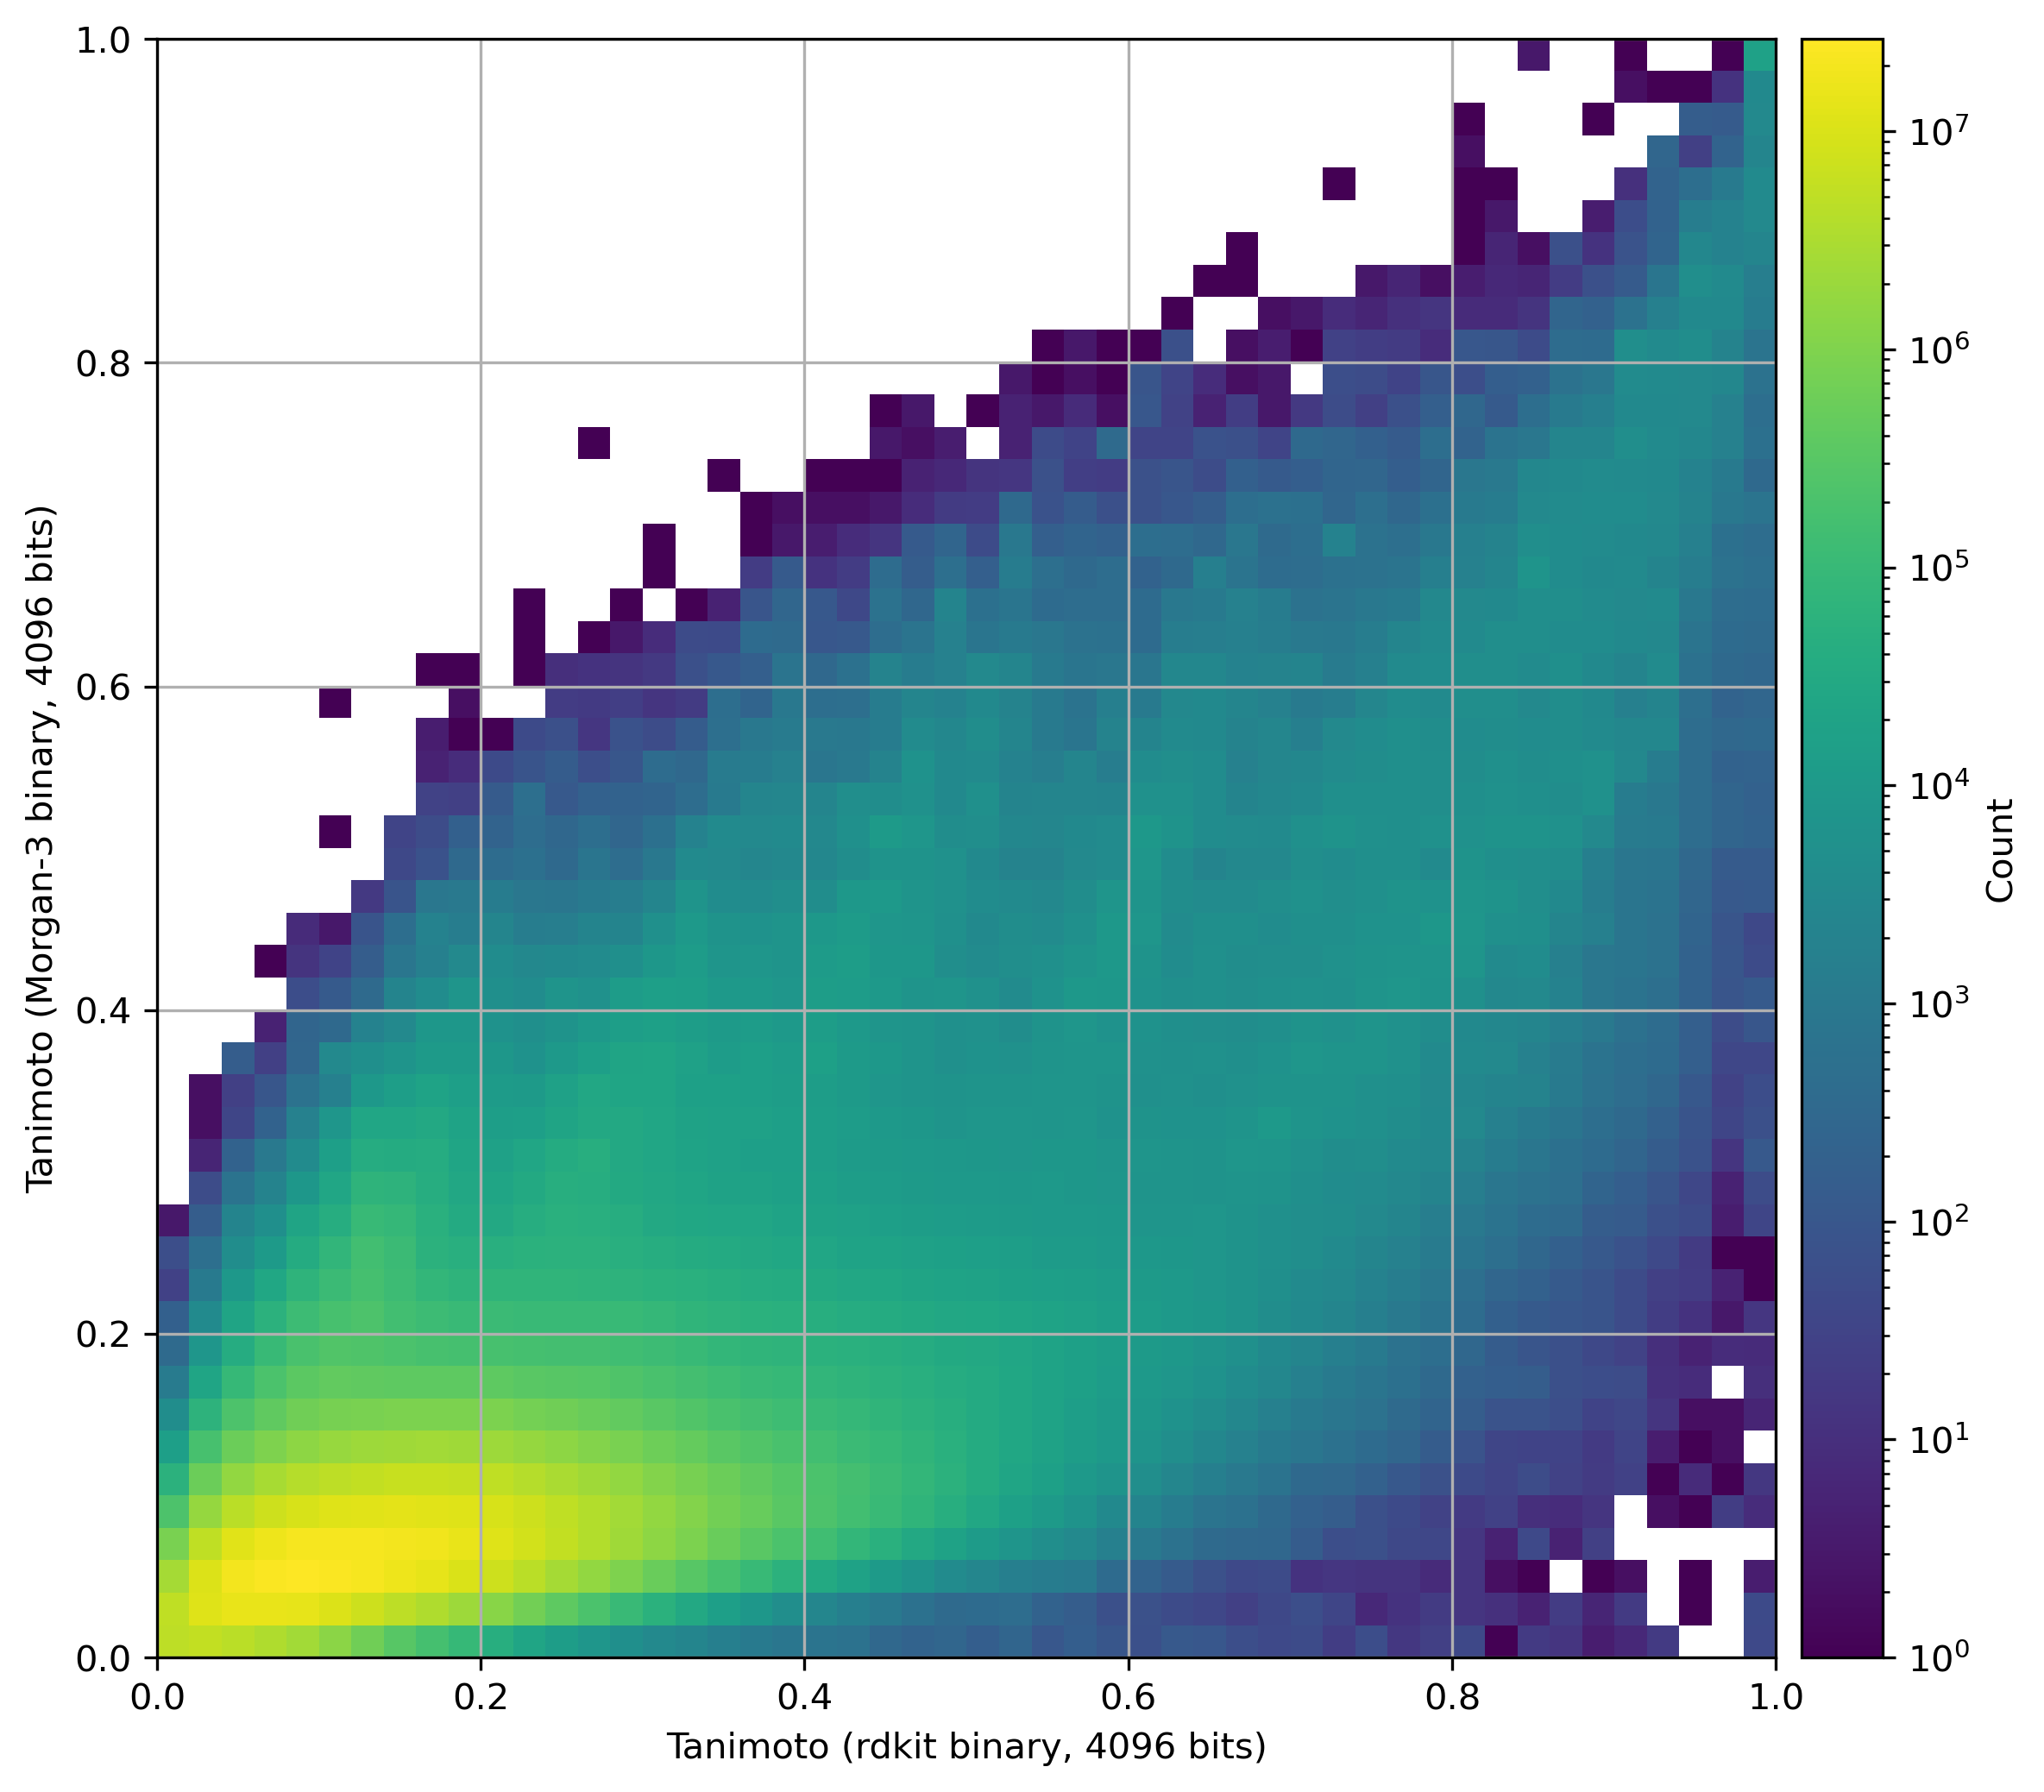

In [15]:
NBITS = 4096

heatmap_comparison(
    similarities_rdkit,
    similarities_morgan3,
    f"Tanimoto (rdkit binary, {NBITS} bits)",
    f"Tanimoto (Morgan-3 binary, {NBITS} bits)",
    bins=50, add_region_percentage=False,
    filename="heatmap_tanimoto_rdkit_vs_tanimoto_morgan3.png"
)

## Tanimoto (rdkit) vs Ruzicka (Morgan-3)

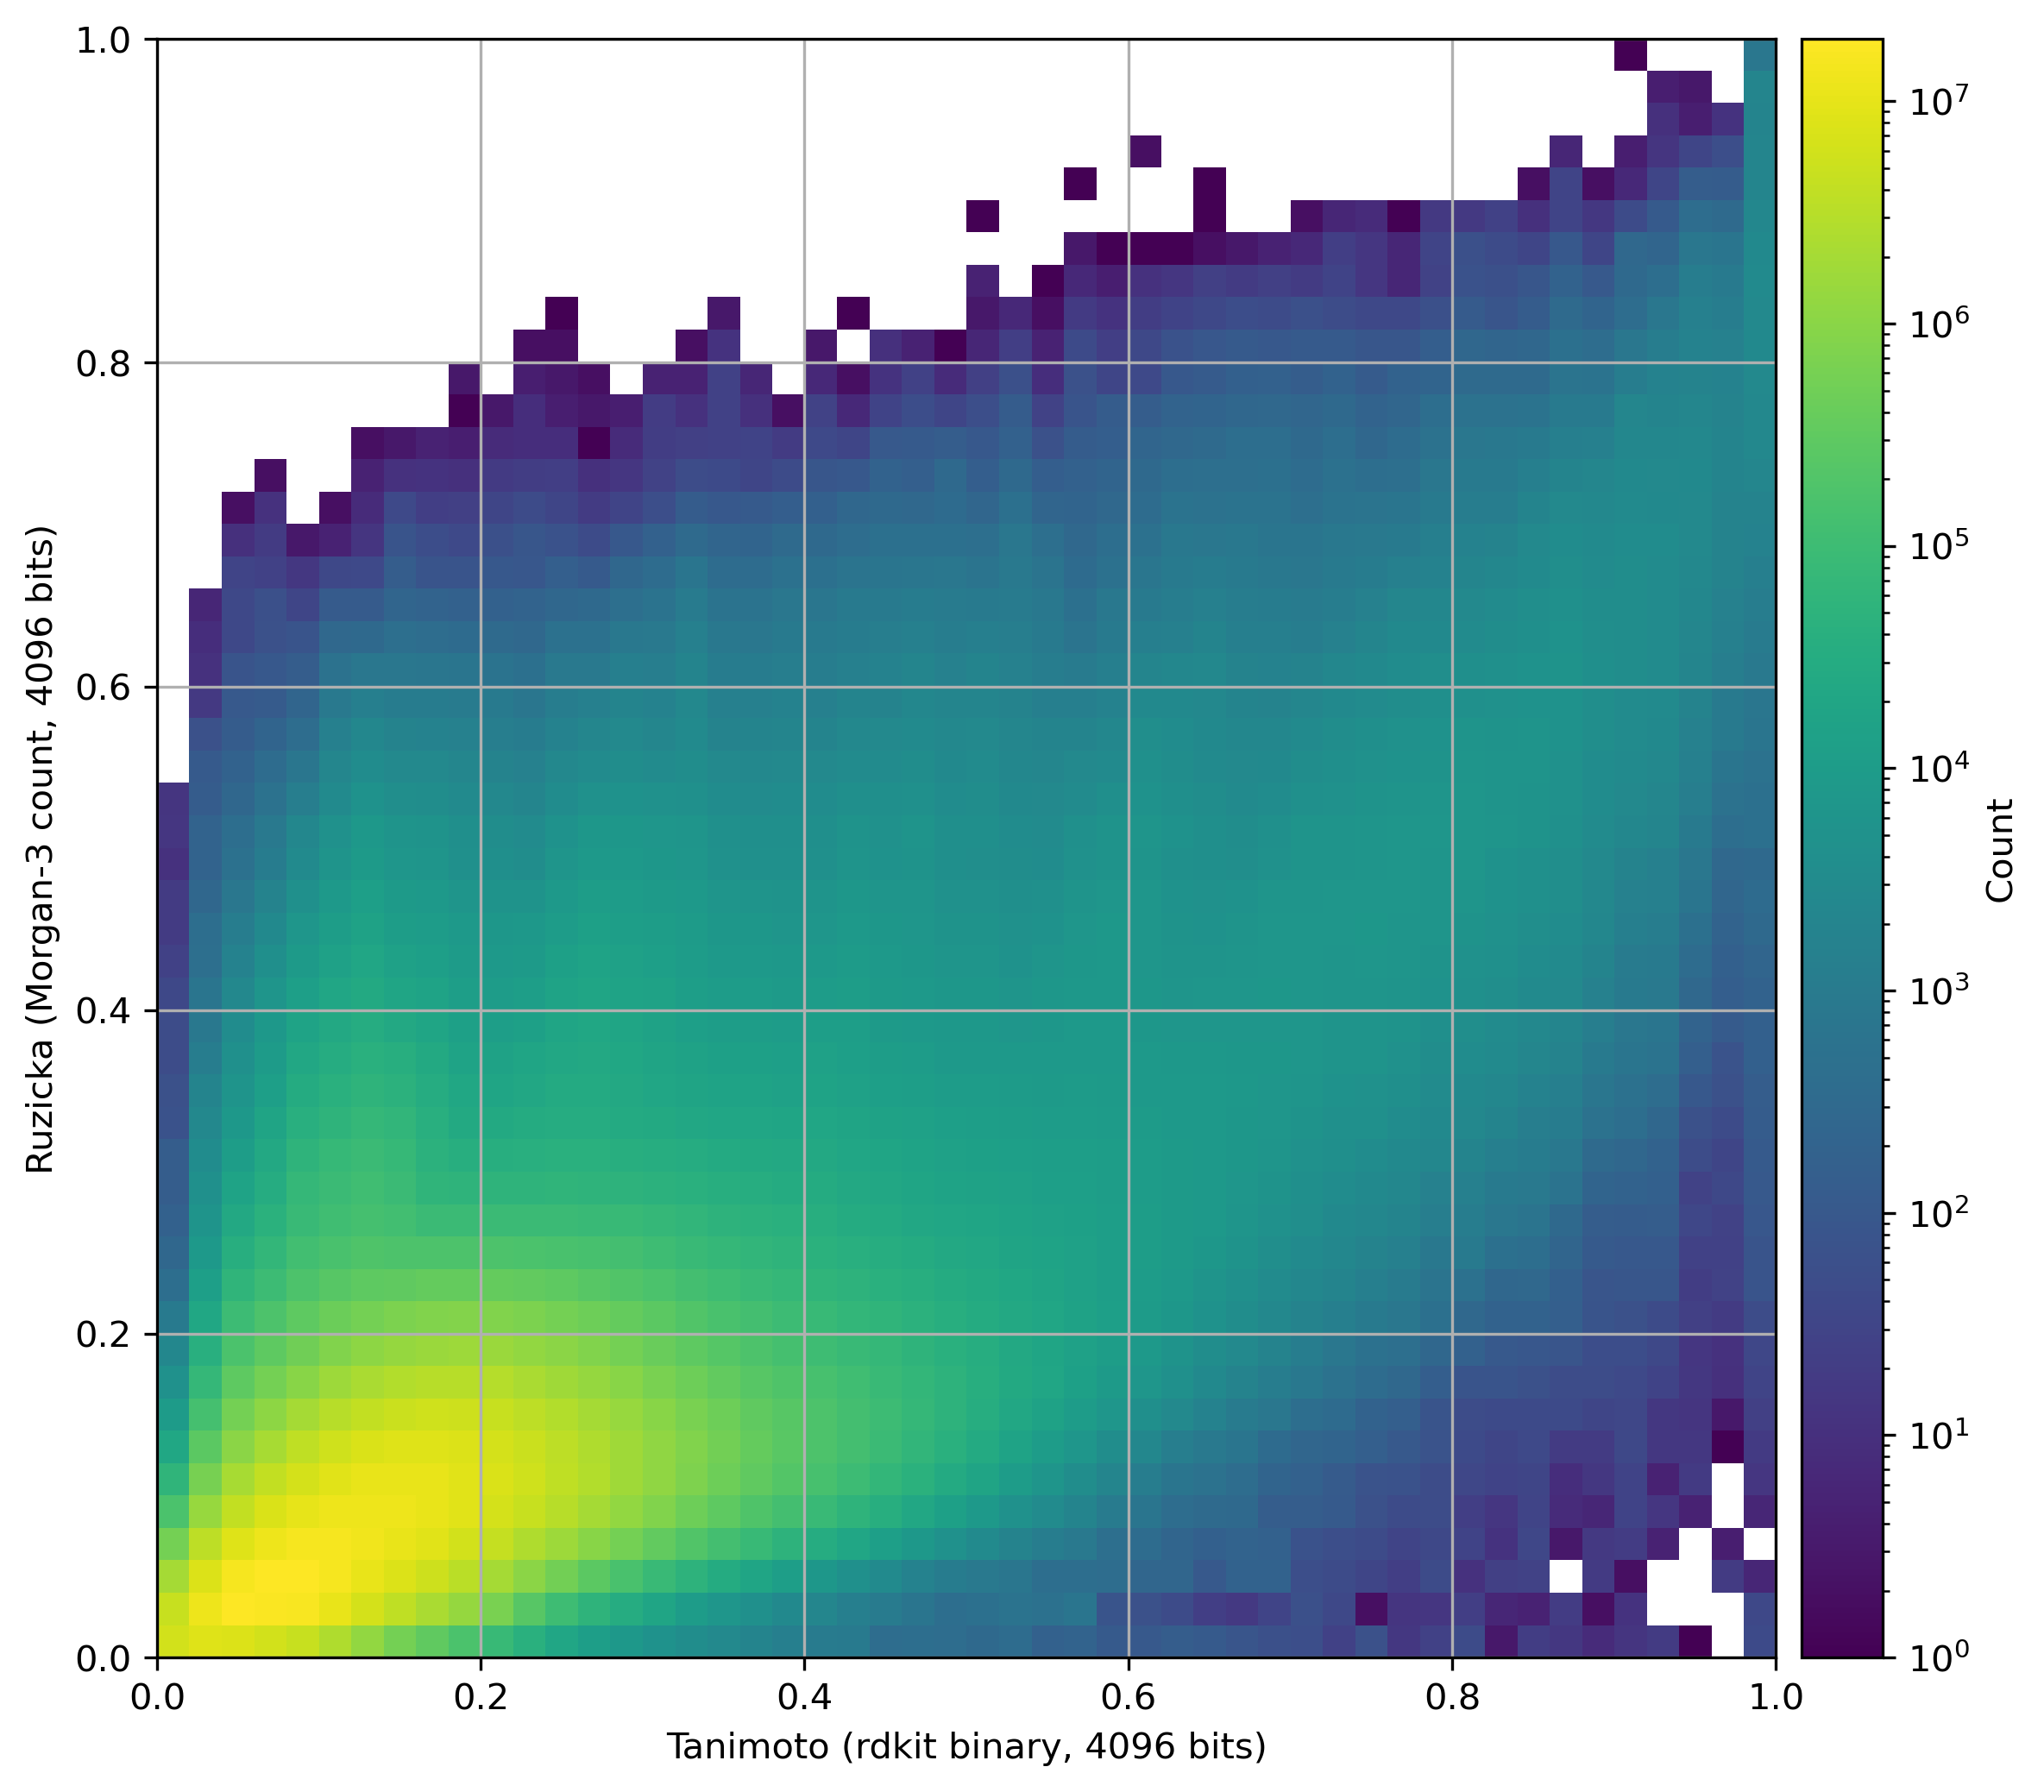

In [9]:
NBITS = 4096

heatmap_comparison(
    similarities_rdkit,
    similarities_morgan3_count,
    f"Tanimoto (rdkit binary, {NBITS} bits)",
    f"Ruzicka (Morgan-3 count, {NBITS} bits)",
    bins=50, add_region_percentage=False,
    filename="heatmap_tanimoto_rdkit_vs_ruzicka_morgan3.png"
)

## Tanimoto (Morgan-3) vs Ruzicka (Morgan-3)

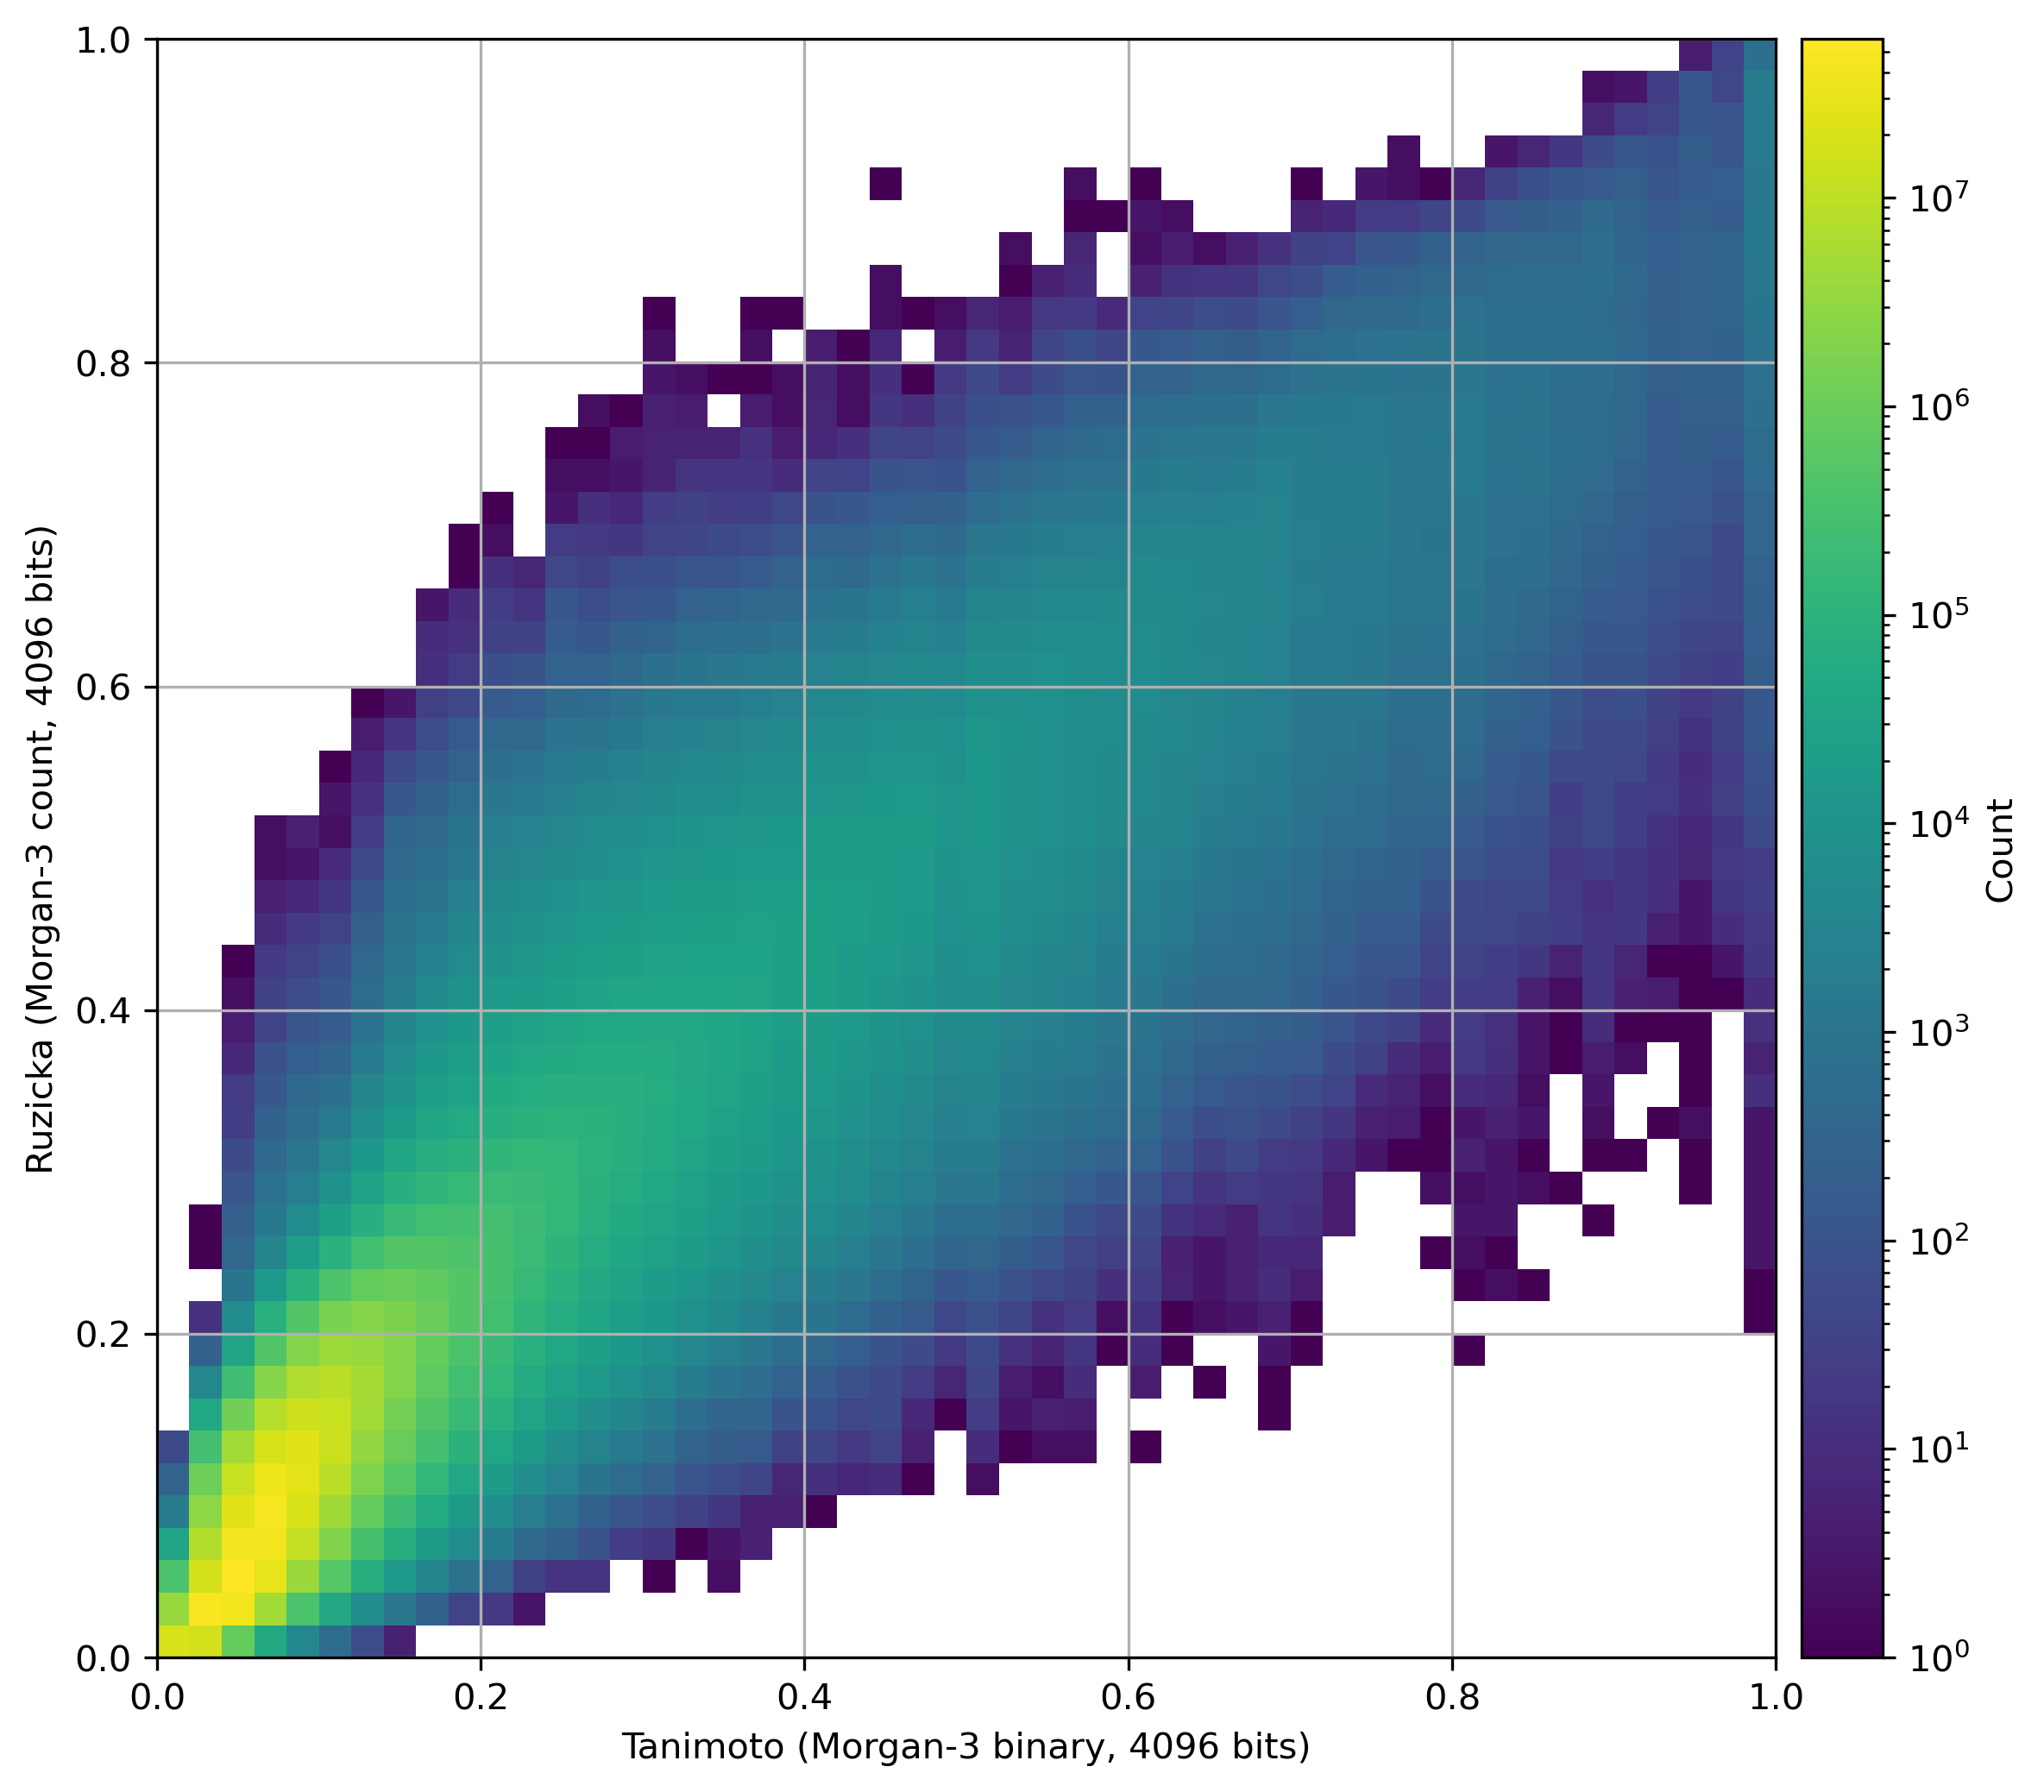

In [10]:
heatmap_comparison(
    similarities_morgan3,
    similarities_morgan3_count,
    f"Tanimoto (Morgan-3 binary, {NBITS} bits)",
    f"Ruzicka (Morgan-3 count, {NBITS} bits)",
    bins=50, add_region_percentage=False,
    filename="heatmap_tanimoto_morgan3_vs_ruzicka_morgan3.png"
)

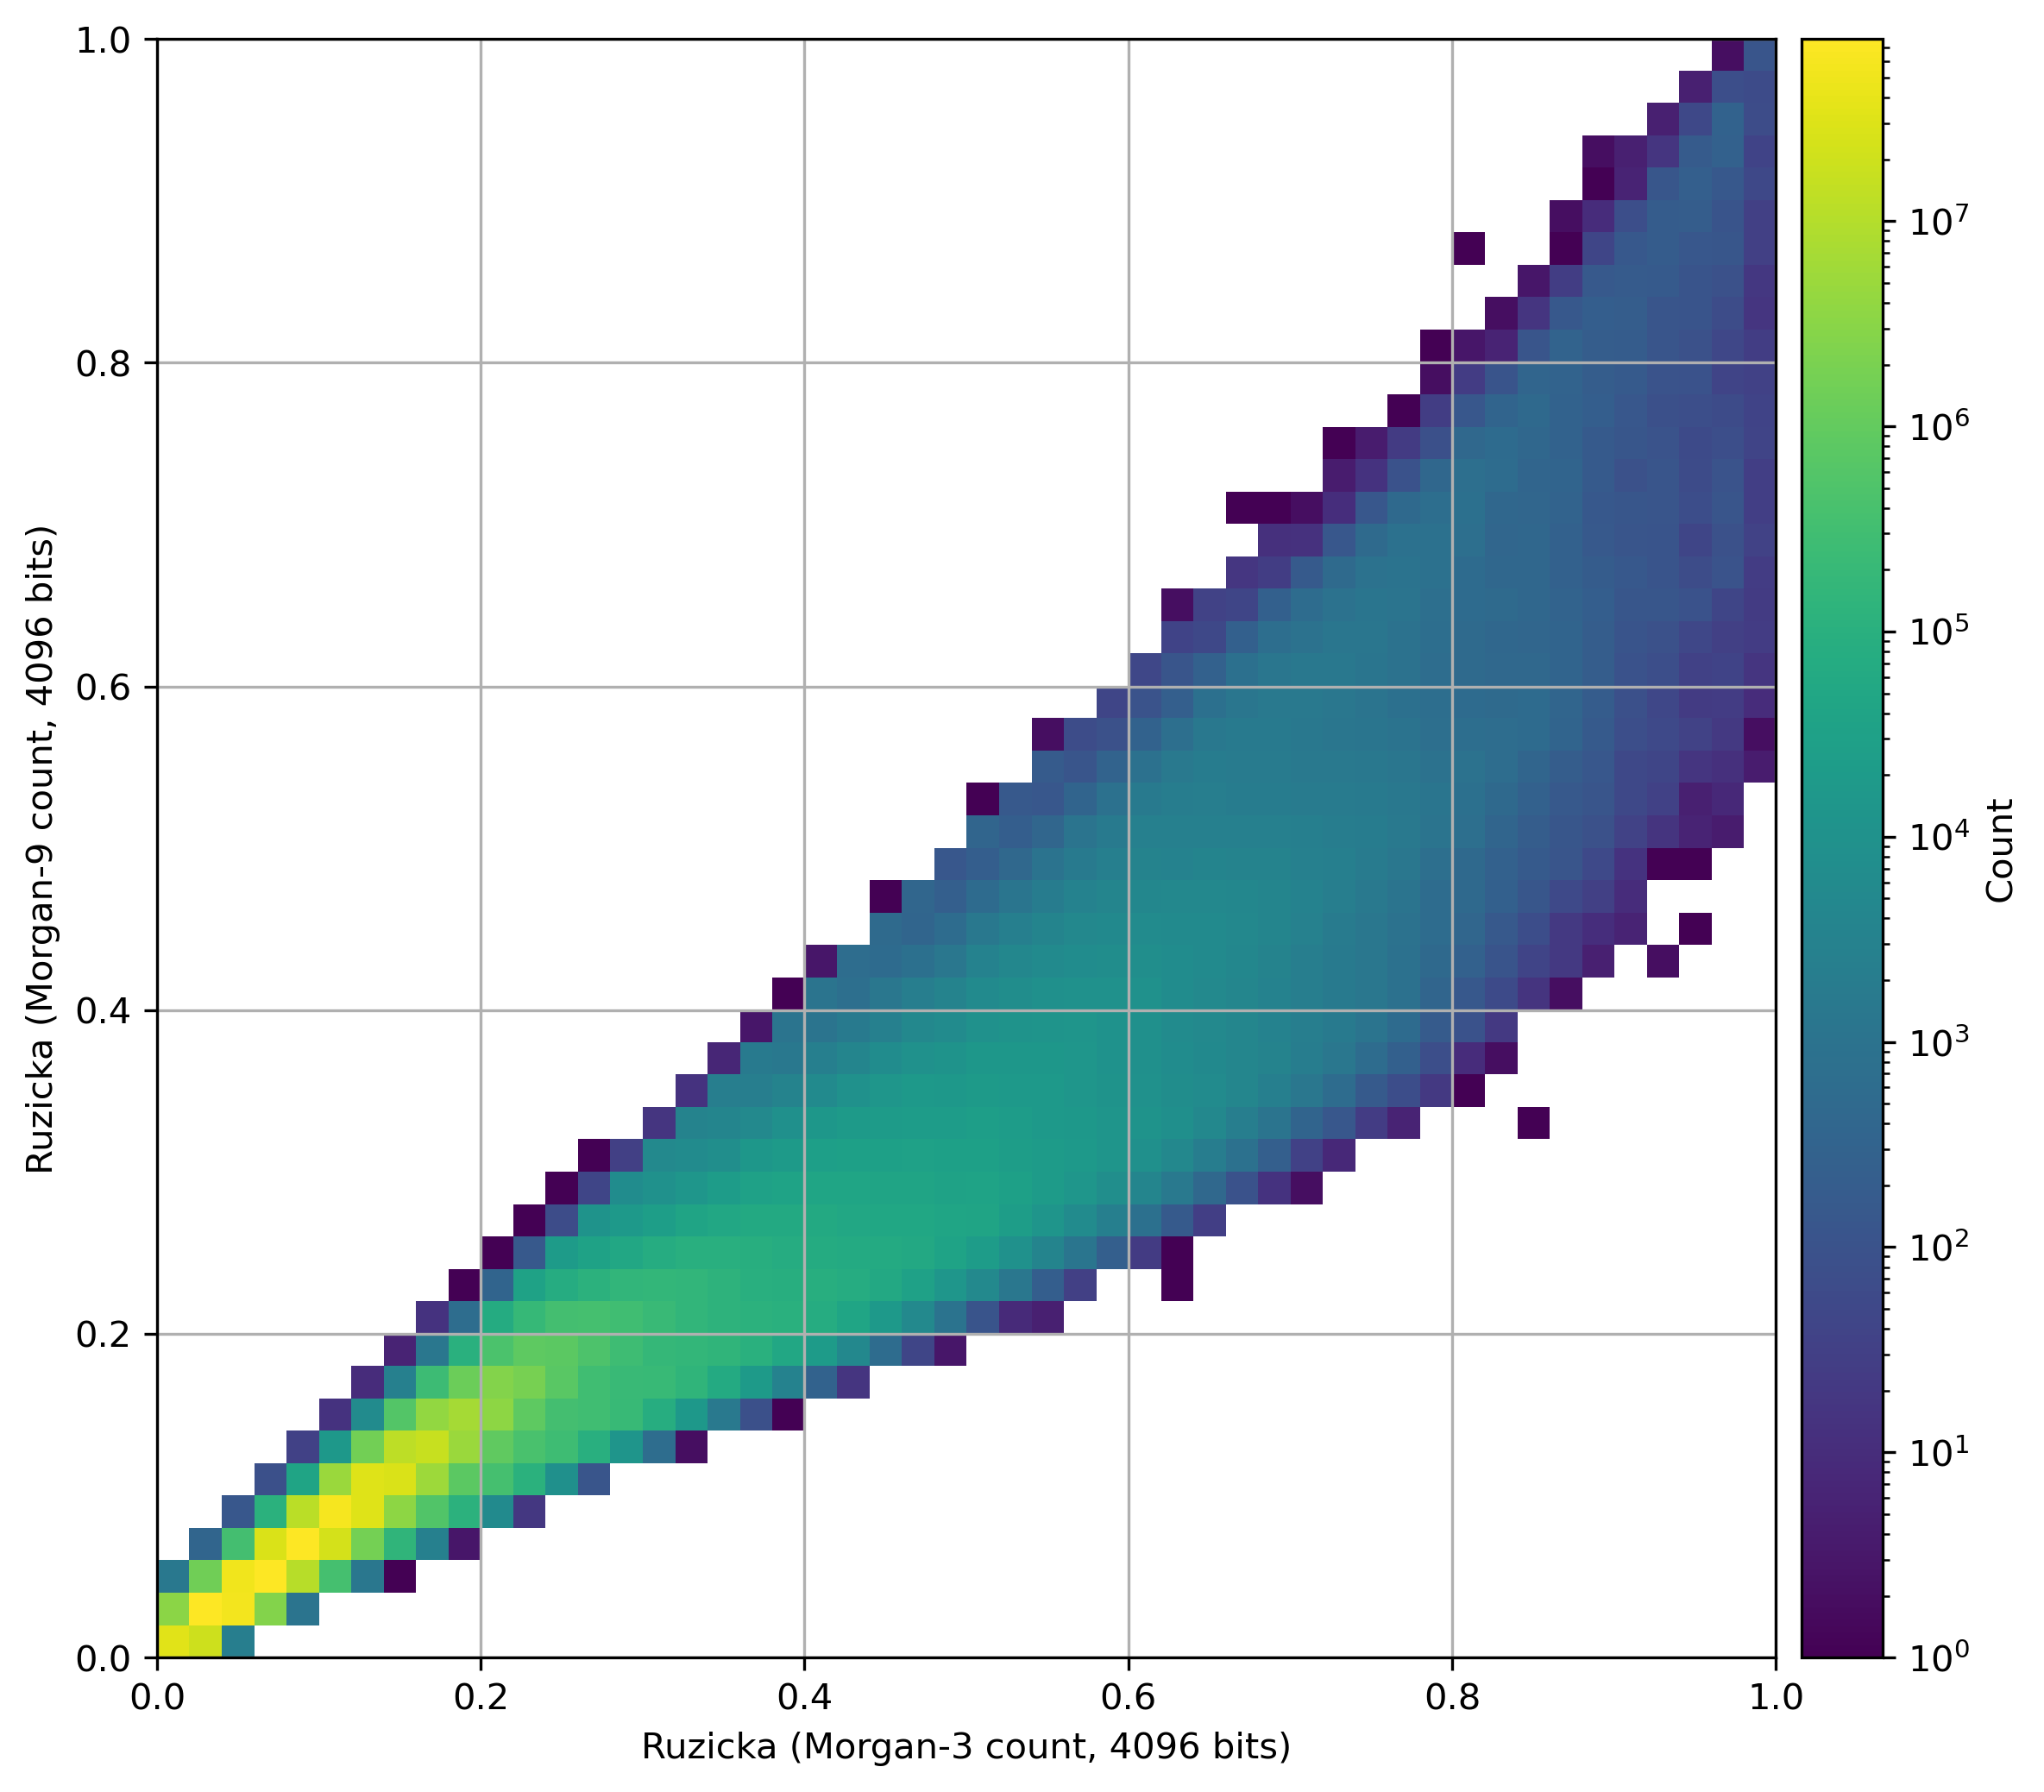

In [11]:
heatmap_comparison(
    similarities_morgan3_count,
    similarities_morgan9_count,
    f"Ruzicka (Morgan-3 count, {NBITS} bits)",
    f"Ruzicka (Morgan-9 count, {NBITS} bits)",
    bins=50, add_region_percentage=False,
    filename="heatmap_ruzicka_morgan3_vs_ruzicka_morgan9.png"
)

## Compare to MAP4

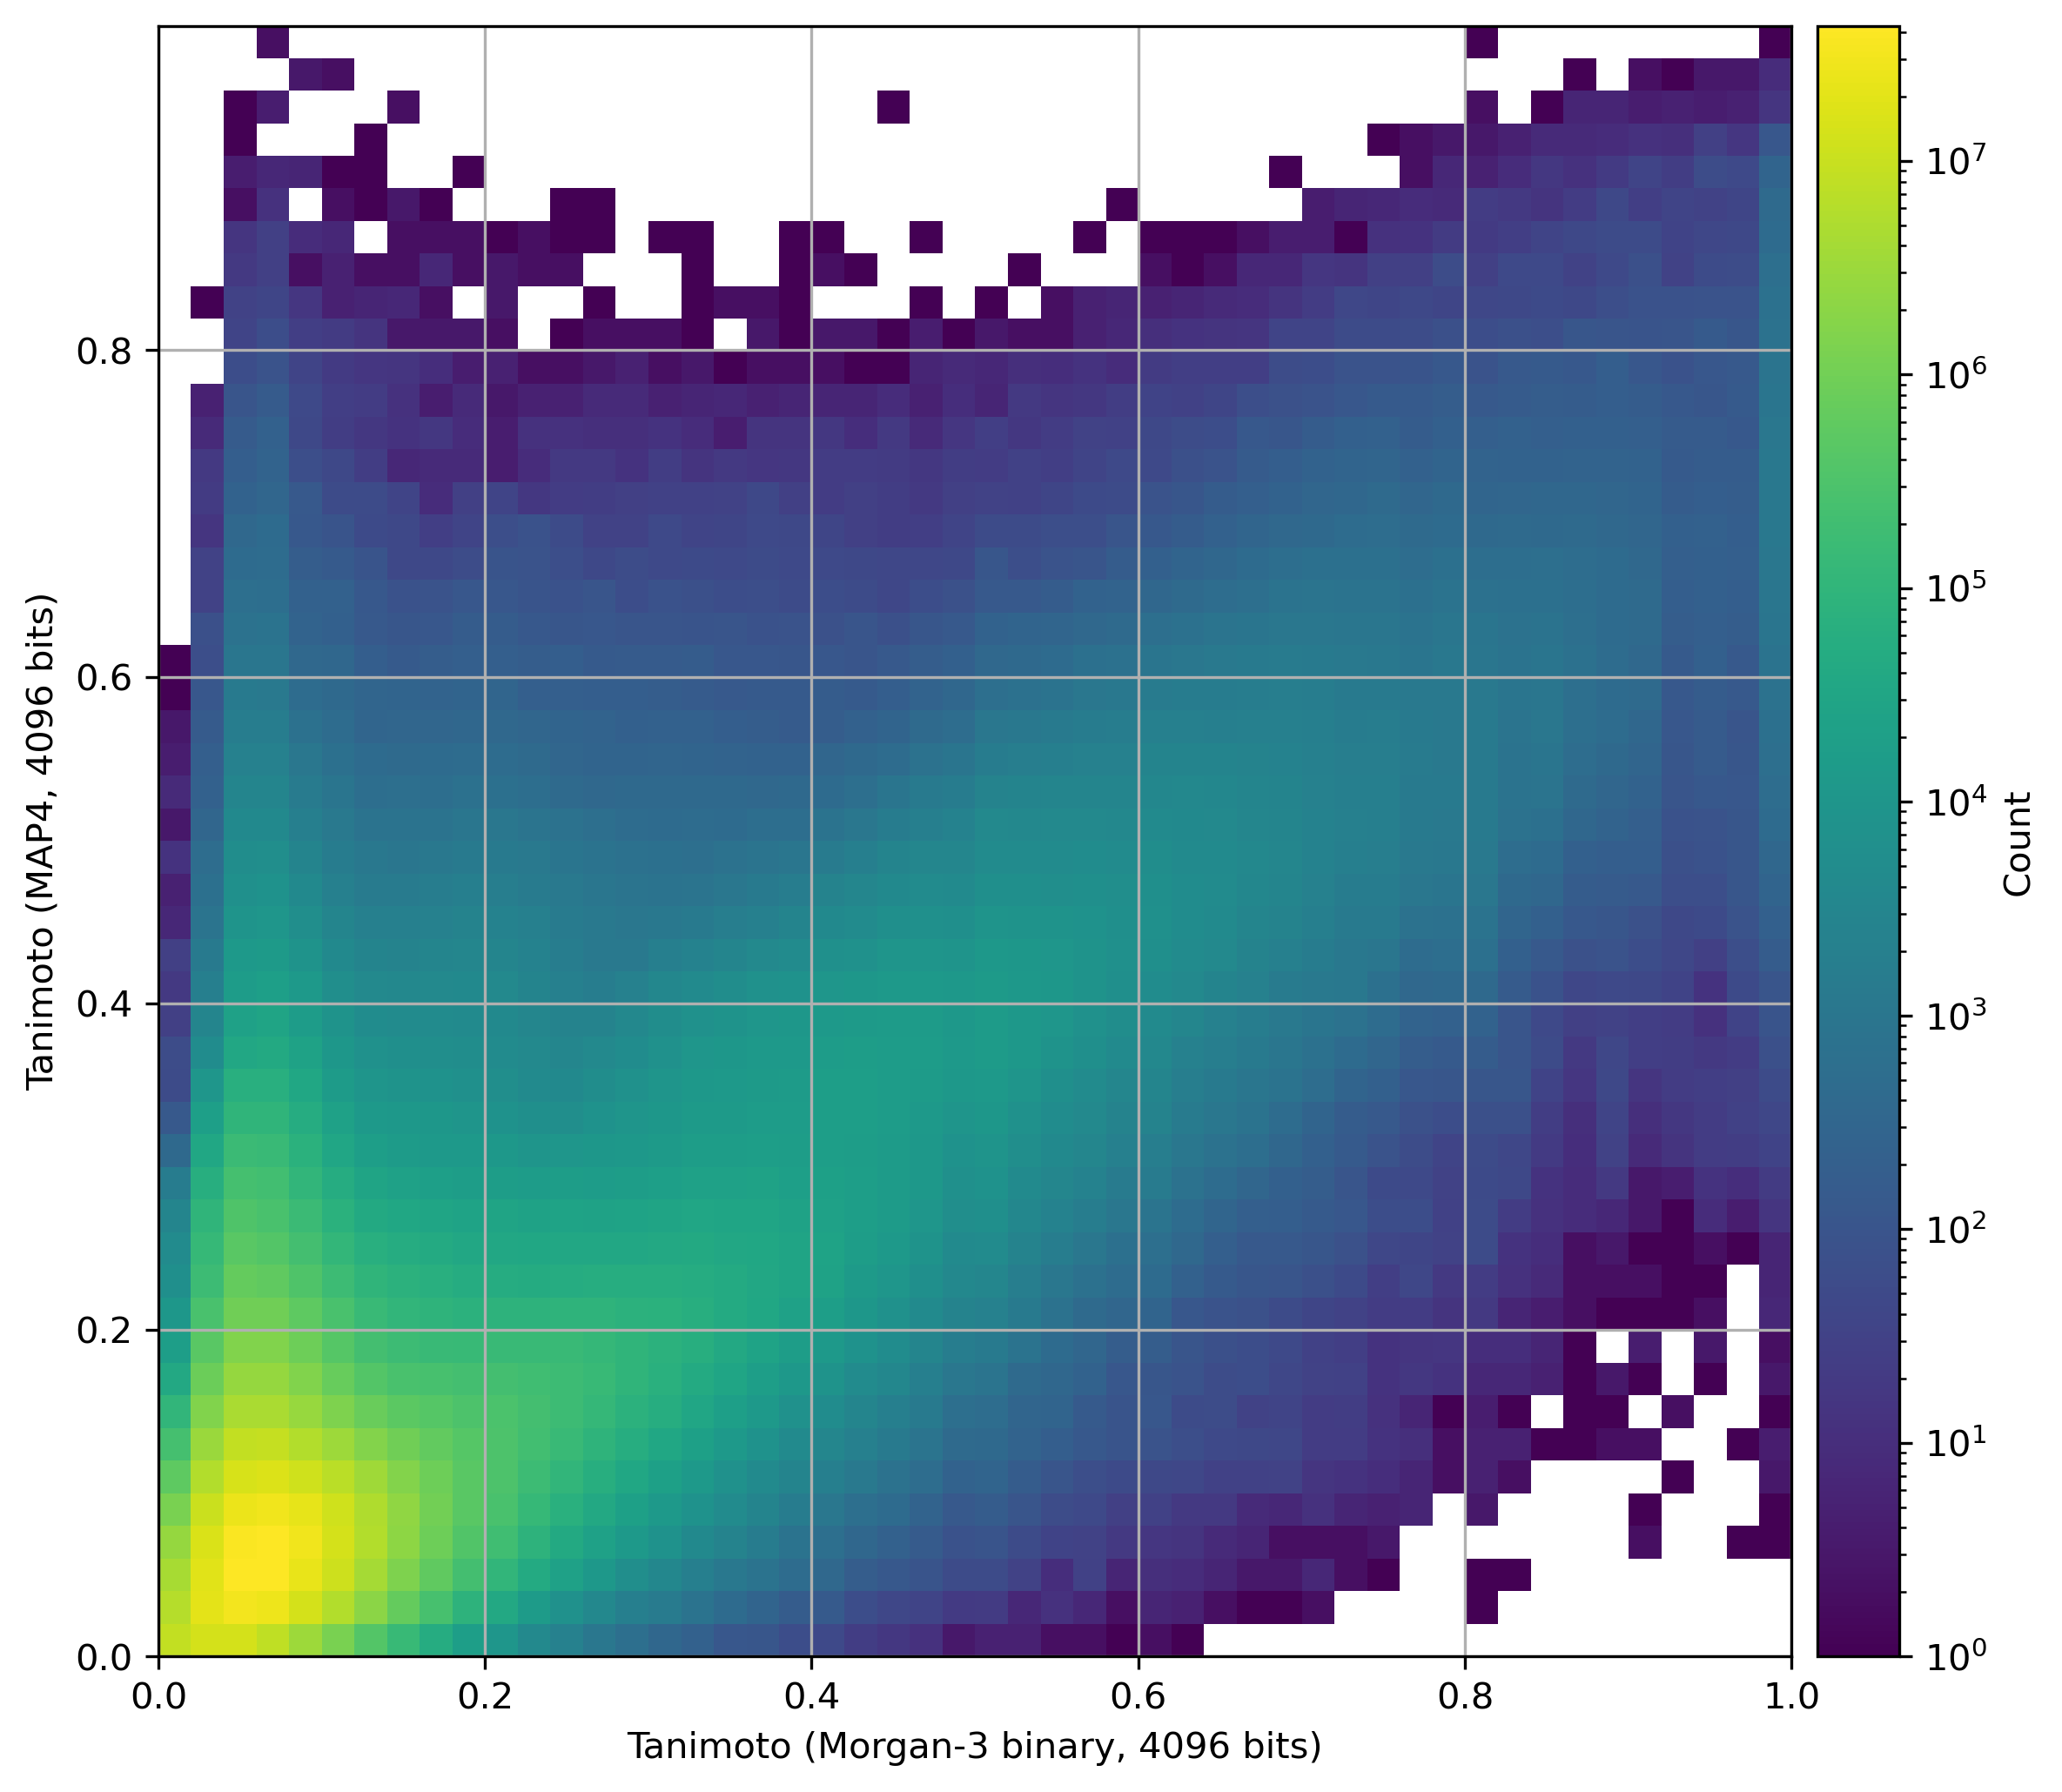

In [21]:
NBITS = 4096

heatmap_comparison(
    similarities_morgan3,
    similarities_map4,
    f"Tanimoto (Morgan-3 binary, {NBITS} bits)",
    f"Tanimoto (MAP4, {NBITS} bits)",
    bins=50, add_region_percentage=False,
    filename="heatmap_tanimoto_morgan3_vs_tanimoto_map4.png"
)

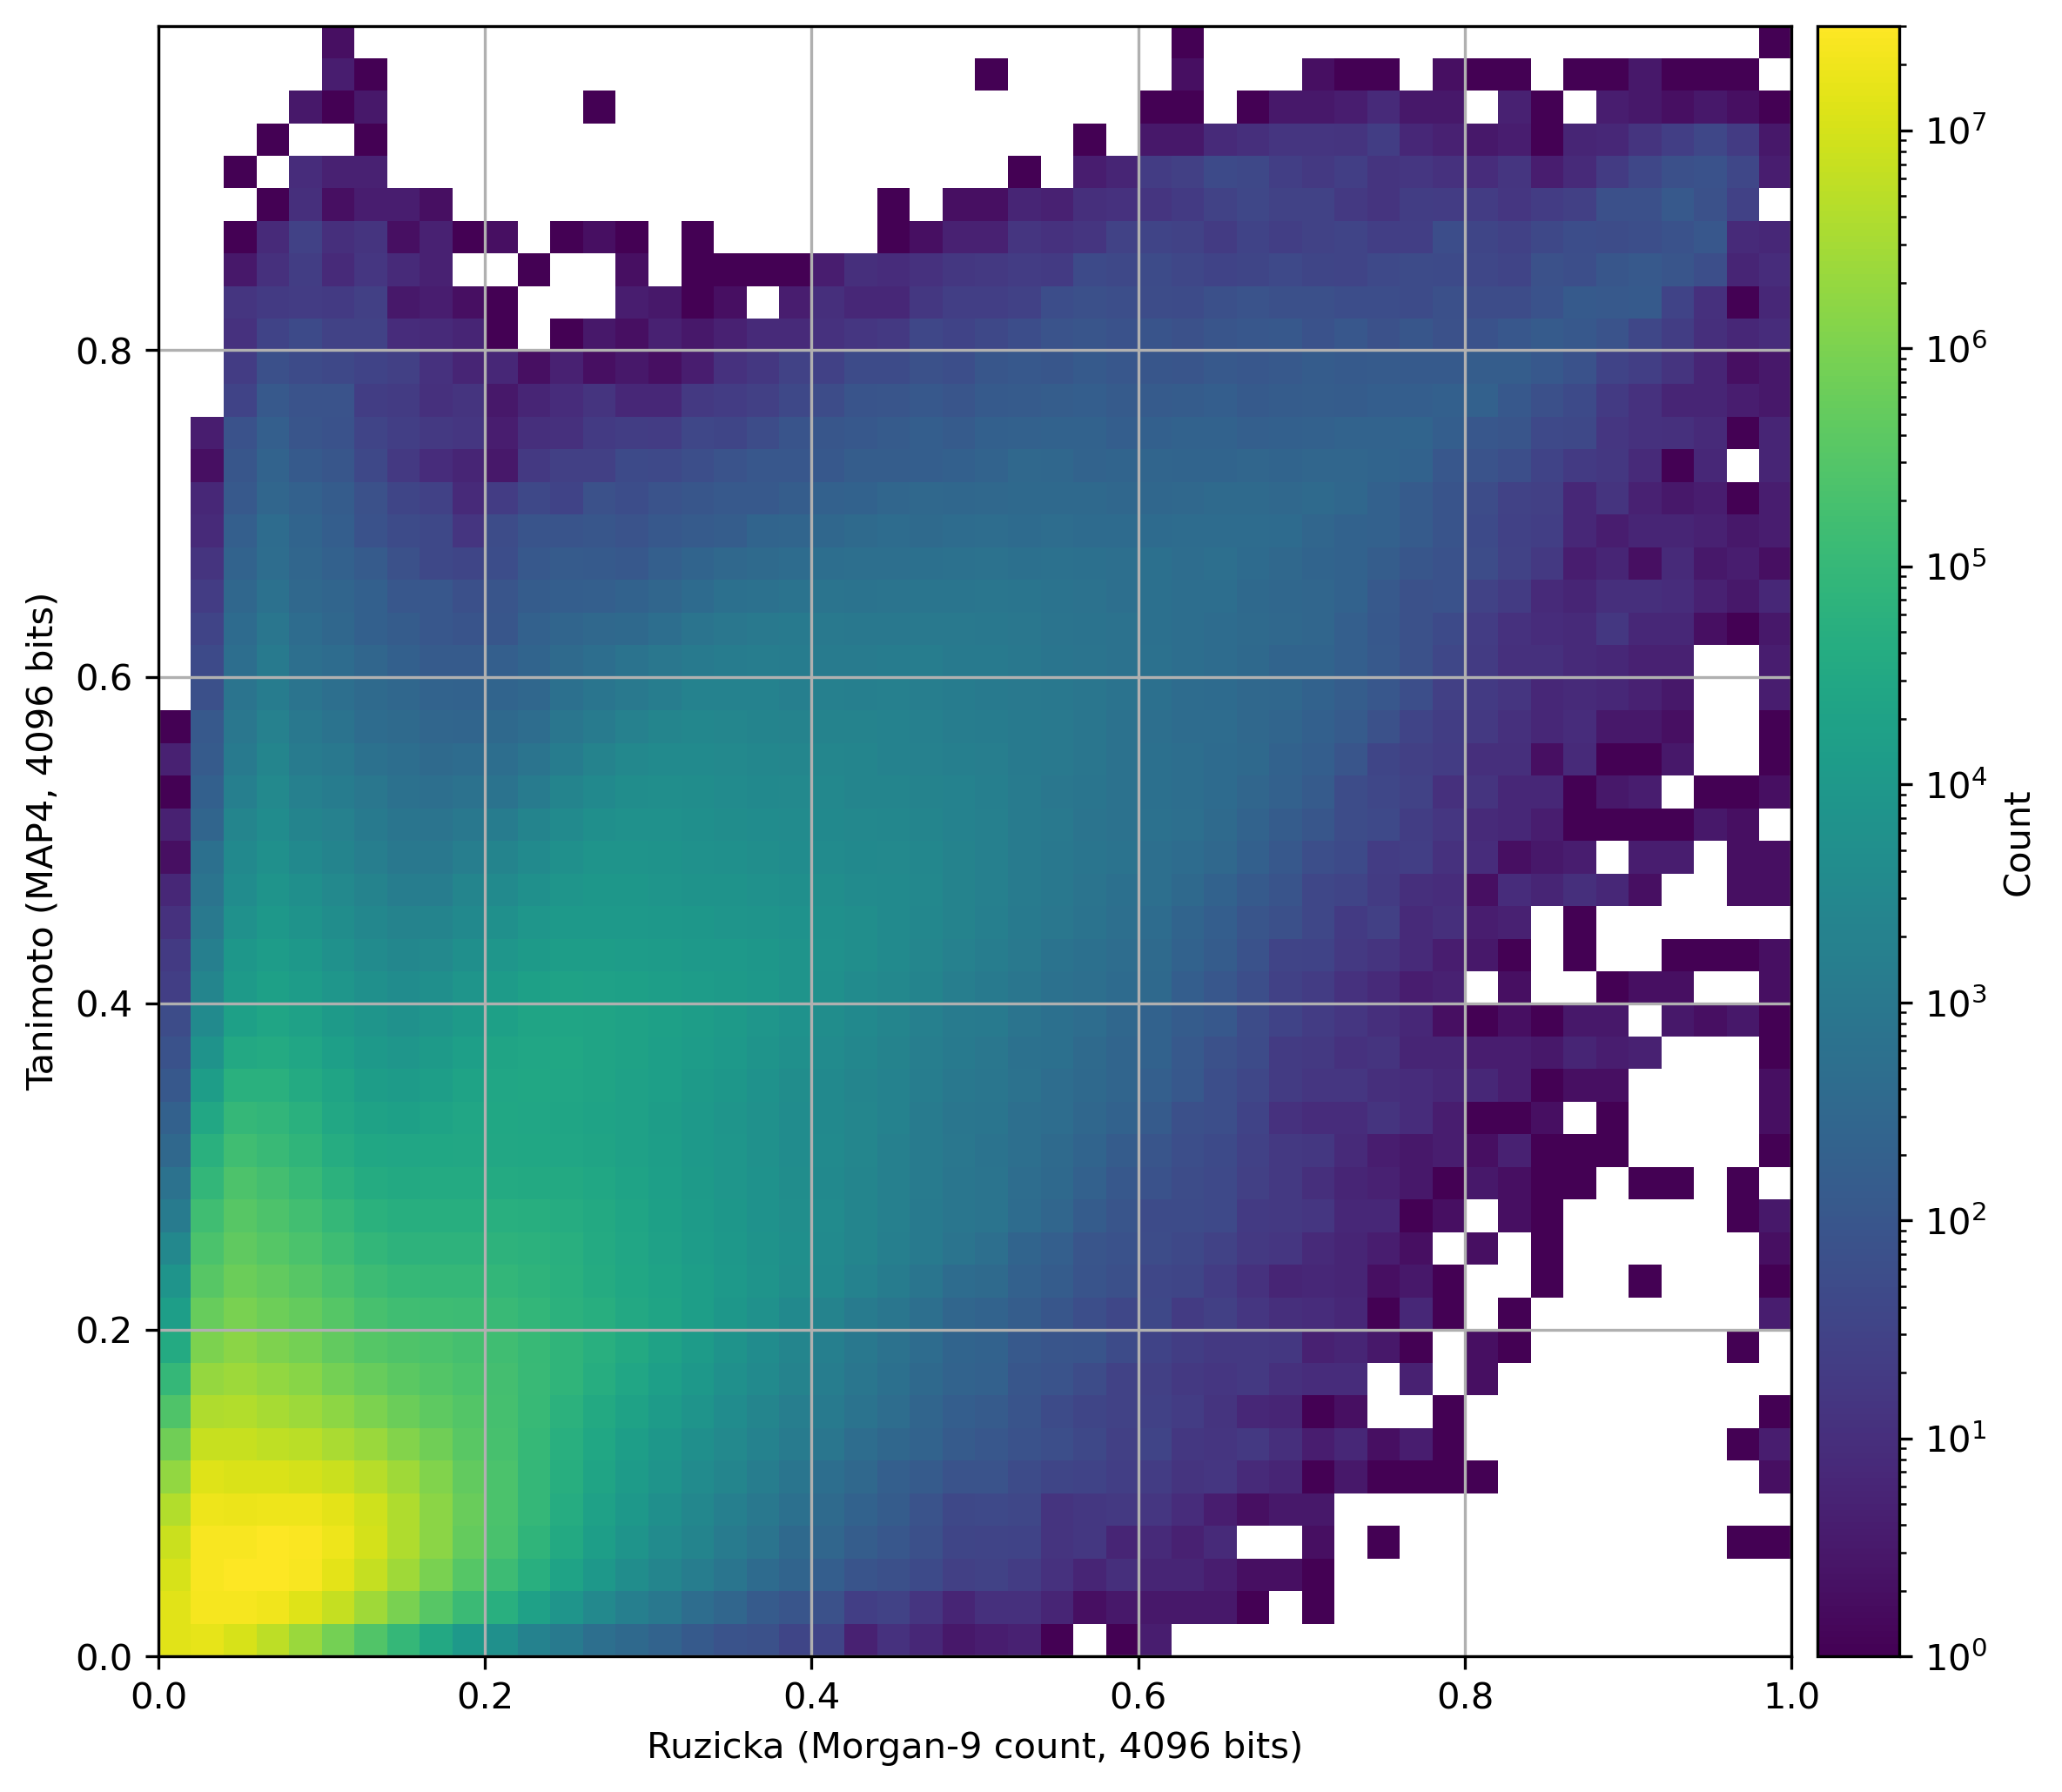

In [22]:
heatmap_comparison(
    similarities_morgan9_count,
    similarities_map4,
    f"Ruzicka (Morgan-9 count, {NBITS} bits)",
    f"Tanimoto (MAP4, {NBITS} bits)",
    bins=50, add_region_percentage=False,
    filename="heatmap_ruzicka_morgan9_vs_tanimoto_map4.png"
)

In [88]:
def get_score_summary(id1, id2):
    scores = {
        "Tanimoto (rdkit binary fp)": similarities_rdkit[id1, id2],
        "Tanimoto (Morgan-3 binary fp)": similarities_morgan3[id1, id2],
        "Tanimoto (MAP4 fp)": similarities_map4[id1, id2],
        "Ruzicka (Morgan-3 count fp)": similarities_morgan3_count[id1, id2],
        "Ruzicka (Morgan-9 count fp)": similarities_morgan9_count[id1, id2],
    }
    scores = pd.DataFrame.from_dict(scores, orient='index', columns=["Score"])
    return scores

In [45]:
def get_score_summary(id1, id2):
    scores = {
        "Tanimoto (rdkit binary fp)": similarities_rdkit[id1, id2],
        "Scaled Tanimoto (Morgan-3 binary fp)": scaled_similarities_morgan3[id1, id2],
        "Scaled Tanimoto (MAP4 fp)": scaled_similarities_map4[id1, id2],
        "Scaled Ruzicka (Morgan-3 count fp)": scaled_similarities_morgan3_count[id1, id2],
        "Scaled Ruzicka (Morgan-9 count fp)": scaled_similarities_morgan9_count[id1, id2],
    }
    scores = pd.DataFrame.from_dict(scores, orient='index', columns=["Score"])
    return scores

In [33]:
def show_pairs(unique_pairs):
    for pair in unique_pairs:
        display(get_score_summary(pair[0], pair[1]))
    
        smiles1 = compounds.smiles[pair[0]]
        smiles2 = compounds.smiles[pair[1]]
        mol = Chem.MolFromSmiles(smiles1)
        display(mol)
        mol = Chem.MolFromSmiles(smiles2)
        display(mol)

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw


def show_pairs_in_grid(unique_pairs, ncols=2, figsize=(30, 18), filename=None):
    nrows = -(-len(unique_pairs) // ncols)  # Ceiling division to get number of rows
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()  # Flatten to iterate easily

    for i, pair in enumerate(unique_pairs):
        id1, id2 = pair
        ax = axes[i]
        
        # Get SMILES and render molecules
        smiles1 = compounds.smiles[pair[0]]
        smiles2 = compounds.smiles[pair[1]]
        mol1 = Chem.MolFromSmiles(smiles1)
        mol2 = Chem.MolFromSmiles(smiles2)
        img = Draw.MolsToGridImage([mol1, mol2], molsPerRow=2, subImgSize=(800, 800), returnPNG=False)
        
        ax.imshow(img)
        ax.axis('off')
        
        # Get and display score summary below the molecules
        scores = get_score_summary(id1, id2)
        ax.set_title(f"Pair {i + 1}")
        ax.text(0.5, 0, scores.to_string(header=False), 
                transform=ax.transAxes, ha='center', fontsize=10, family='monospace')
    
    # Hide any unused subplots if number of pairs is less than grid size
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()


In [43]:
# MANUAL CURATION!
selected_pairs_high12_low345 = [(769, 13201), (40, 36045), (11277, 11759),
                                (629, 4118), (709, 25756),
                                (279, 17156), (161, 27494)
                               ]

selected_pairs_high1245_low3 = [(3746, 7282), (1787, 22304), (4509, 36134)]

selected_pairs_low123_high45 = [(1151, 37592), (1398, 16827)]

selected_pairs_low1245_high3 = [(206, 28321), (562, 24300), (24440, 37563), (1495, 4507), (1495, 10679), (12197, 30695)]

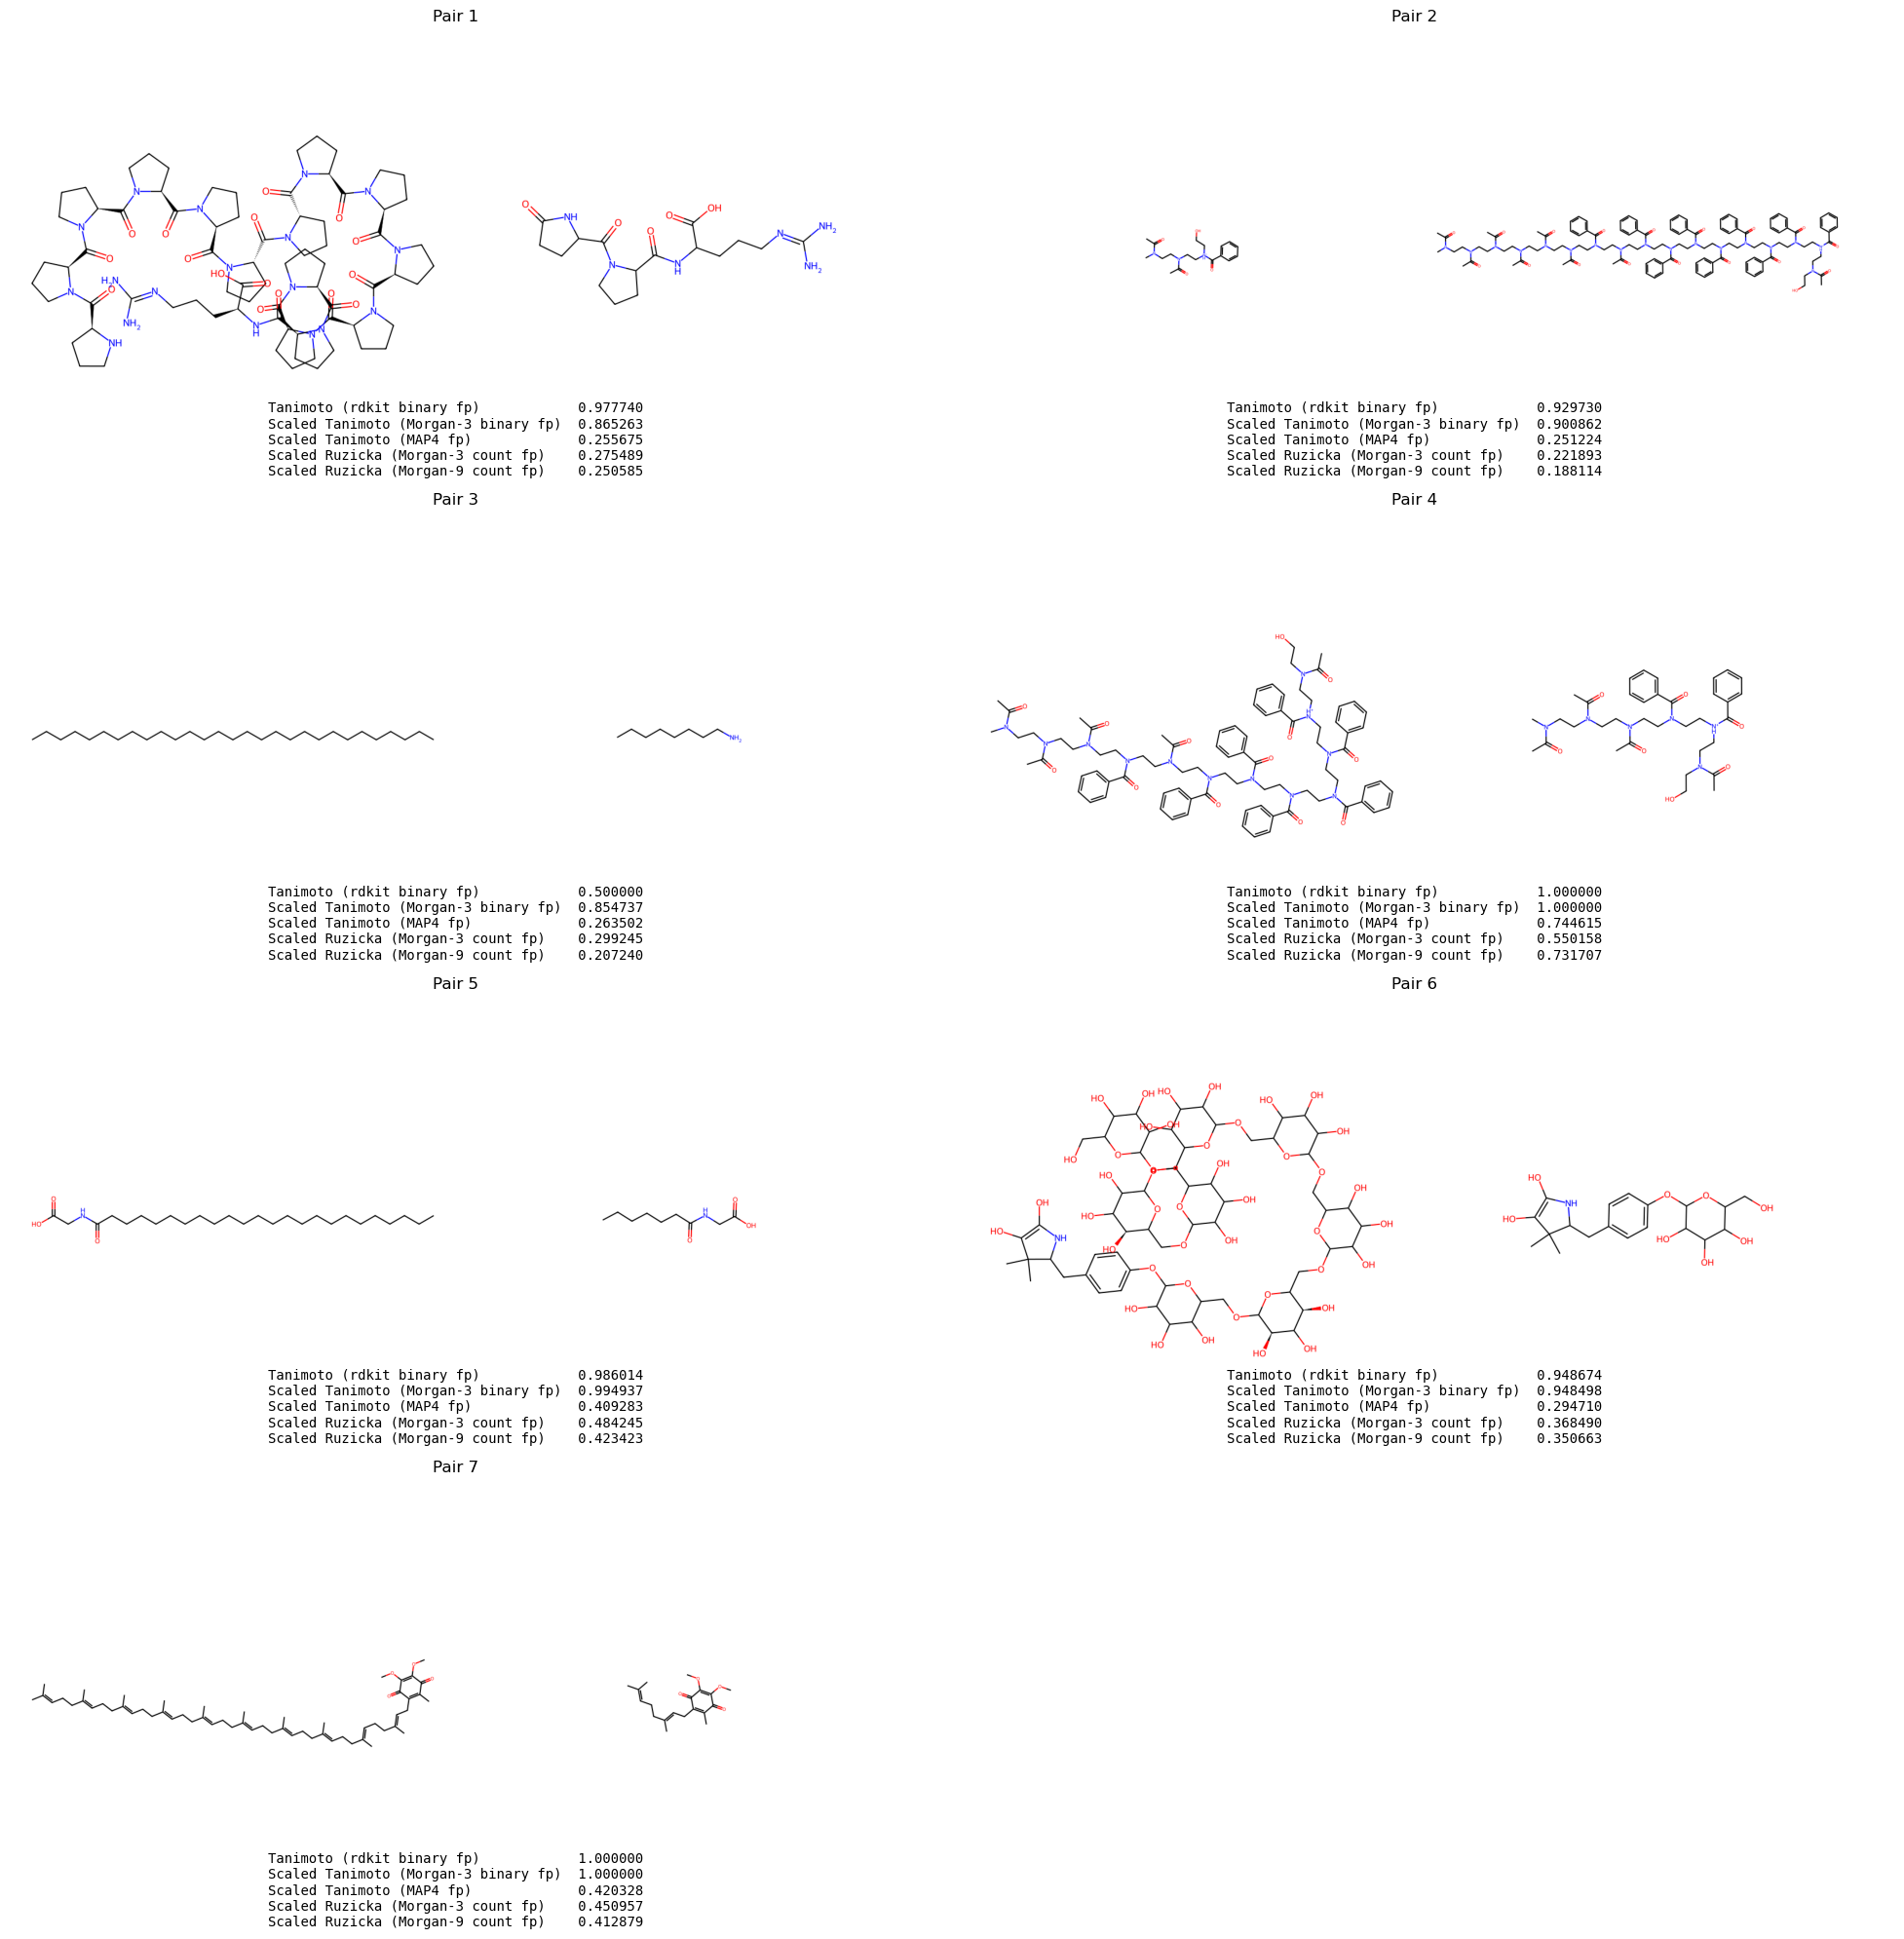

In [47]:
show_pairs_in_grid(selected_pairs_high12_low345, ncols=2, figsize=(20, 20),
                   filename="selected_pairs_high12_low345.png"
                  )

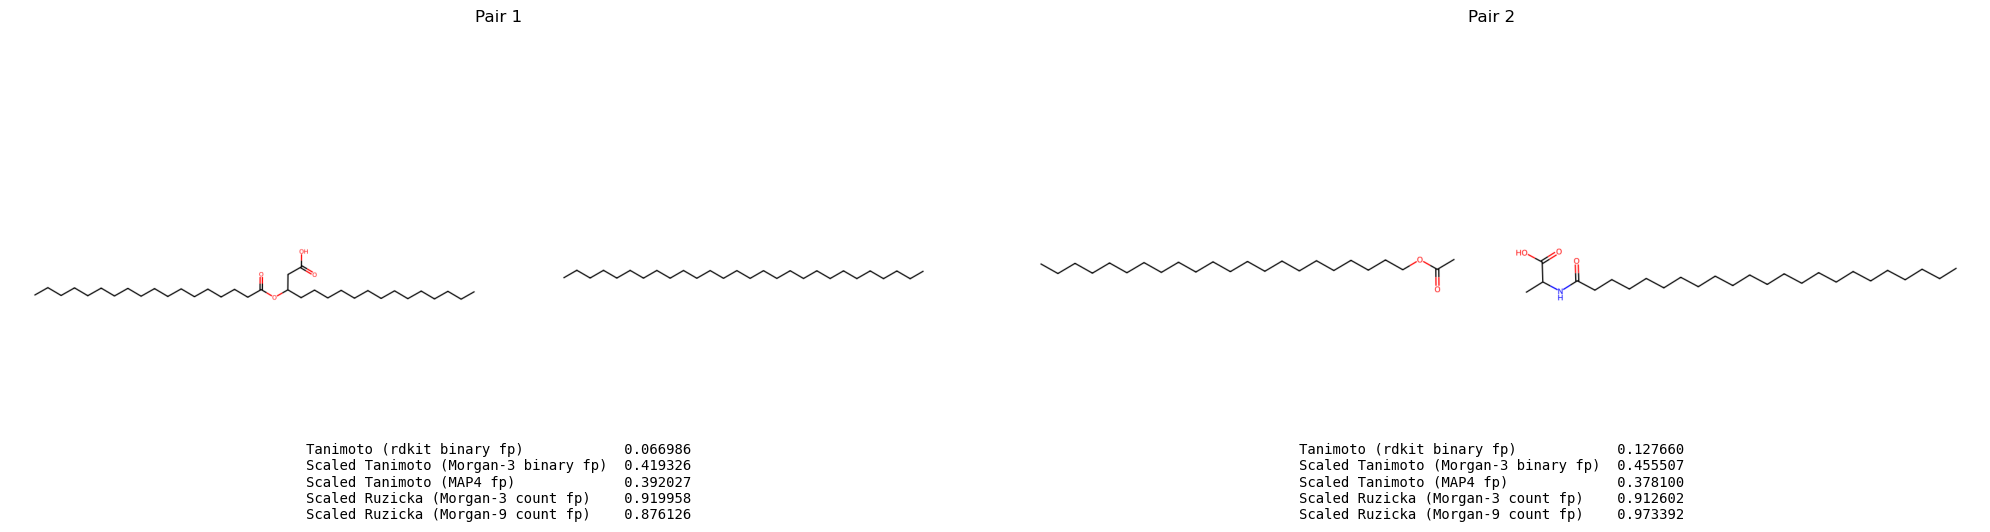

In [48]:
show_pairs_in_grid(selected_pairs_low123_high45 , ncols=2, figsize=(20, 20),
                   filename="selected_pairs_low123_high45.png"
                  )

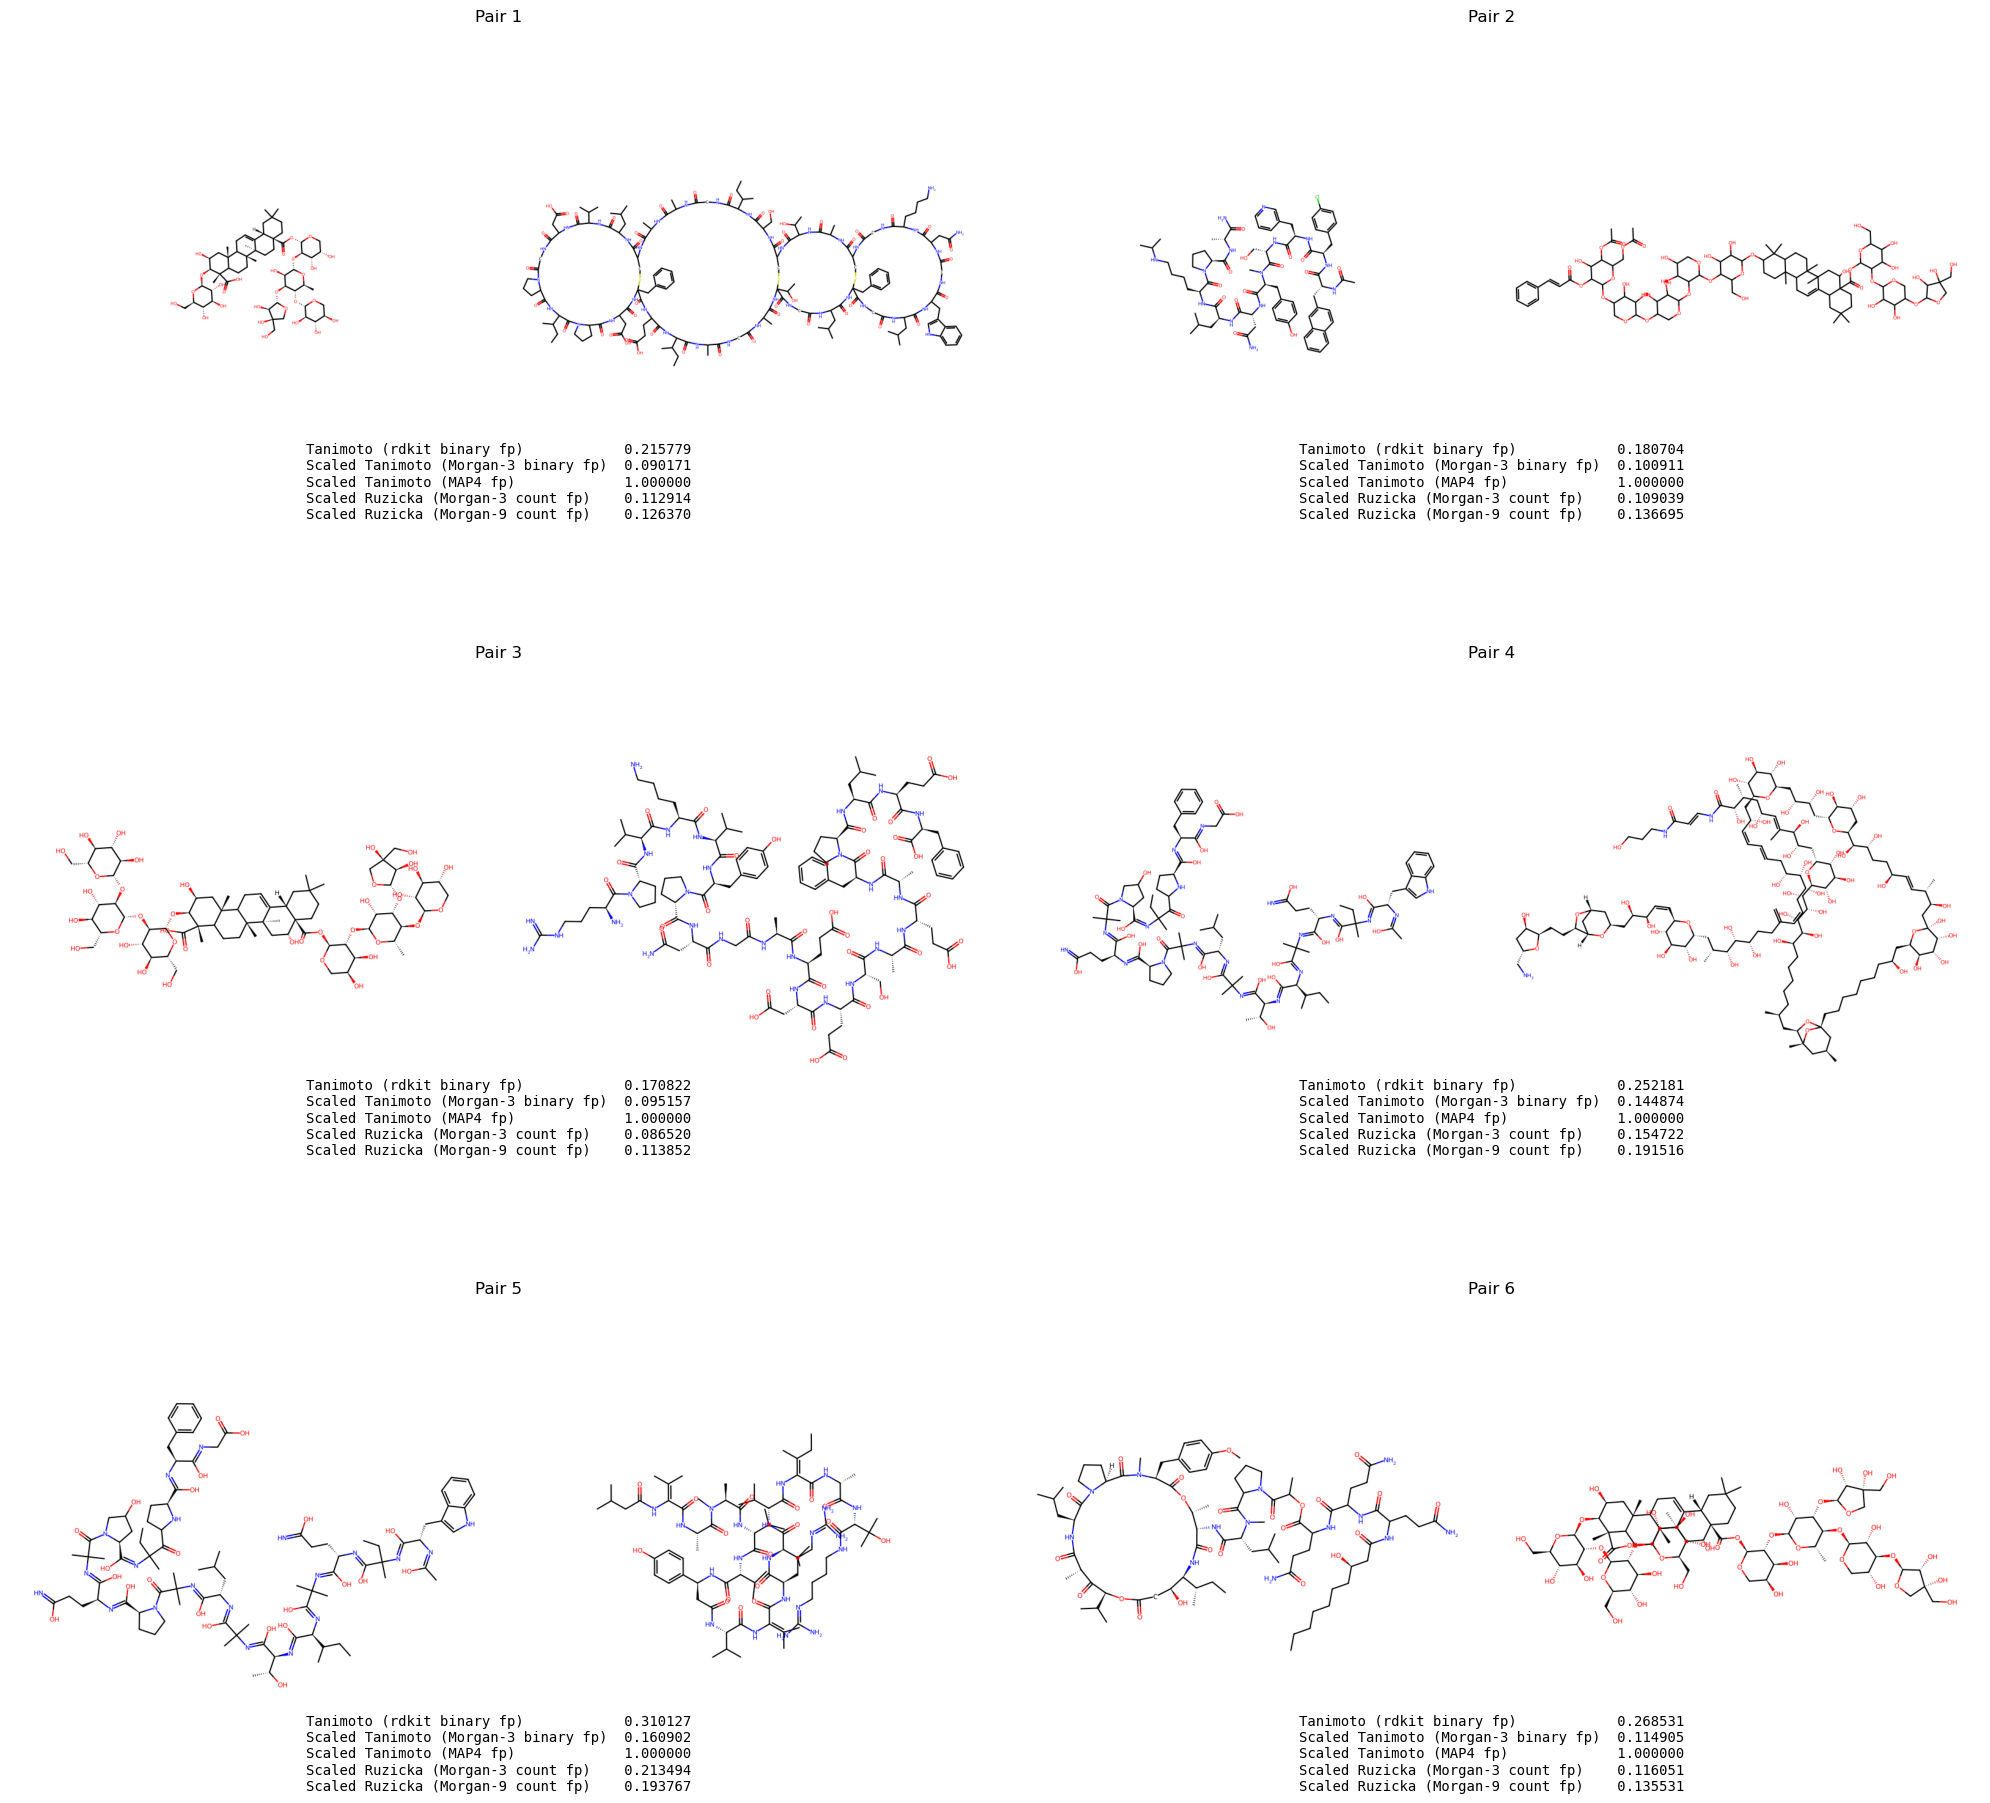

In [50]:
show_pairs_in_grid(selected_pairs_low1245_high3 , ncols=2, figsize=(20, 20),
                   filename="selected_pairs_low1245_high3.png"
                  )

In [38]:
idx = np.where((scaled_similarities_morgan3_count > 0.8) \
               & (scaled_similarities_morgan3 < 0.35) \
               #& (similarities_map4 > 0.5)
              )
idx[0].shape

(242,)

In [149]:
idx = np.where((similarities_morgan3_count > 0.9) \
               #& (similarities_morgan3 < 0.2) \
               & (similarities_map4 < 0.4)
              )
idx[0].shape

(240,)

In [145]:
# idx = np.where(np.abs(similarities_morgan3_count - similarities_morgan3) > 0.5) 
idx = np.where(((similarities_morgan3_count - similarities_morgan3) < -0.5) \
               & (similarities_map4 > 0.5)
              ) 
idx[0].shape

(18,)